## Incomes


In [2]:
import pandas as pd
import pmdarima as pm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

aug_trainset = pd.read_csv('data/Anexos_7/training/total_incomes_augmented_training_data.csv')
testset = pd.read_csv('data/Anexos_7/test/total_incomes_test_data.csv')
original_trainset = pd.read_csv('data/Anexos_7/training/total_incomes_training_data.csv')
# Convert the 'Date' column to datetime format
aug_trainset['Date'] = pd.to_datetime(aug_trainset['Date'], format='%Y-%m-%d')
testset['Date'] = pd.to_datetime(testset['Date'], format='%Y-%m-%d')
original_trainset['Date'] = pd.to_datetime(original_trainset['Date'], format='%Y-%m-%d')


testset.set_index('Date', inplace=True)
aug_trainset.set_index('Date', inplace=True)
original_trainset.set_index('Date', inplace=True)

In [12]:
from sklearn.model_selection import ParameterGrid

def auto_arima_train(train, param_grid):
    d_from_diff = {}
    models = {}
    ignore_cols = ['Day', 'Month', 'Year', 'DayOfYear']
    provinces = [col for col in train.columns if col not in ignore_cols]
    
    for province in provinces:
        curr_train = train[[province]]
        
        # Grid search for hyperparameter tuning
        best_model = None
        best_params = {"seasonal": True, 'stepwise': False,"maxiter": 50, "out_of_sample": 0}
        best_aic = float('inf')
        
        for params in ParameterGrid(param_grid):
            model = pm.auto_arima(curr_train, 
                                  seasonal=params['seasonal'], 
                                  stepwise=params['stepwise'], 
                                  maxiter=params['maxiter'], 
                                  out_of_sample_size=params['out_of_sample'], 
                                  suppress_warnings=True)
            
            if model.aic() < best_aic:
                best_aic = model.aic()
                best_model = model
                best_params['seasonal'] = params['seasonal']
                best_params['stepwise'] = params['stepwise']
                best_params['maxiter'] = params['maxiter']
                best_params['out_of_sample'] = params['out_of_sample']
        
        models[province] = best_model

        # Check for stationarity and apply differencing if needed
        d = 0
        result = adfuller(curr_train[province])
        while result[1] > 0.05:
            curr_train = curr_train.diff().dropna()
            d += 1
            result = adfuller(curr_train[province])
        d_from_diff[province] = d
        print(f"Best parameters for province '{province}': (d={d} from differencing, d={best_model.order[1]} d from AutoArima)\n")
        for p in best_params:
            print(f'{p}: {best_params[p]}')
        # Create subplots for ACF and PACF
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        plot_acf(curr_train[province], ax=axes[0])
        plot_pacf(curr_train[province], ax=axes[1])
        axes[0].set_title(f'ACF for {province} (MA={best_model.order[2]})')
        axes[1].set_title(f'PACF for {province} (AR={best_model.order[0]})')
        plt.tight_layout()
        plt.show()
    
    return models, d_from_diff





def evaluate_model(models, d_from_diff, train, test):
    for province in models.keys():
        auto_model = models[province]
        curr_test = test[province]
        curr_train = train[province]
        auto_predictions = auto_model.predict(n_periods=len(curr_test))
        d = d_from_diff[province]
    # Fit ARIMA model on the training set
        model = ARIMA(curr_train, order = (auto_model.order[0], d, auto_model.order[2]))
        model_fit = model.fit()
        # Make predictions on the test set
        predictions = model_fit.forecast(steps=len(curr_test))
        print(f' AutoArima Predictions for {province}: incomes. d = {auto_model.order[1]}') 
        print(auto_predictions)
        print()
        print(f'Arima Predictions for {province}: incomes. d = {d}') 
        print(predictions)


        # Calculate evaluation metrics
        auto_mae = mean_absolute_error(curr_test, auto_predictions)
        auto_mse = mean_squared_error(curr_test, auto_predictions)
        auto_rmse = np.sqrt(auto_mse)
        auto_mape = np.mean(np.abs((curr_test - auto_predictions) / curr_test)) * 100
        auto_nmse = auto_mse / np.var(curr_test)
        # Calculate evaluation metrics
        mae = mean_absolute_error(curr_test, predictions)
        mse = mean_squared_error(curr_test, predictions)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((curr_test - predictions) / curr_test)) * 100
        nmse = mse / np.var(curr_test)

        print(f'MAE for autoArima: {auto_mae}')
        print(f'MSE for autoArima: {auto_mse}')
        print(f'RMSE for autoArima: {auto_rmse}')
        print(f'MAPE for autoArima: {auto_mape}%')
        print(f'NMSEfor autoArima: {auto_nmse}')

        print()
        print(f'MAE for ARIMA: {mae}')
        print(f'MSE for ARIMA: {mse}')
        print(f'RMSE for ARIMA: {rmse}')
        print(f'MAPE for ARIMA: {mape}%')
        print(f'NMSE for ARIMA: {nmse}')


        # Plot prediction against test and training trends
        
        plt.figure(figsize=(12,8))
        plt.title(f"Predictions for {province}")
        plt.plot(curr_train, label="Training")
        plt.plot(curr_test, label="Test")
        plt.plot(curr_test.index, auto_predictions, label="AutoArima Predicted", color = 'green')
        plt.plot(curr_test.index, predictions, label='Arima Predicted', color='red')
        plt.legend()
        plt.show()




        # # Plot actual vs predicted values
        # plt.figure(figsize=(10, 6))
        # plt.plot(curr_test.index, curr_test, 'o', label='Actual') # Use 'o' for markers 
        # plt.plot(curr_test.index, auto_predictions, 'x', label='AutoArima Predicted', color='red') # Use 'x' for markers 
        # plt.legend()
        # plt.show()

        # # Plot actual vs predicted values
        # plt.figure(figsize=(10, 6))
        # plt.plot(curr_test.index, curr_test, 'o', label='Actual') # Use 'o' for markers 
        # plt.plot(curr_test.index, predictions, 'x', label='Arima Predicted', color='red') # Use 'x' for markers 
        # plt.legend()
        # plt.show()
        print(model_fit.summary()) 


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmo

Best parameters for province 'Pinar del Rio': (d=1 from differencing, d=1 d from AutoArima)

seasonal: True
stepwise: True
maxiter: 50
out_of_sample: 0


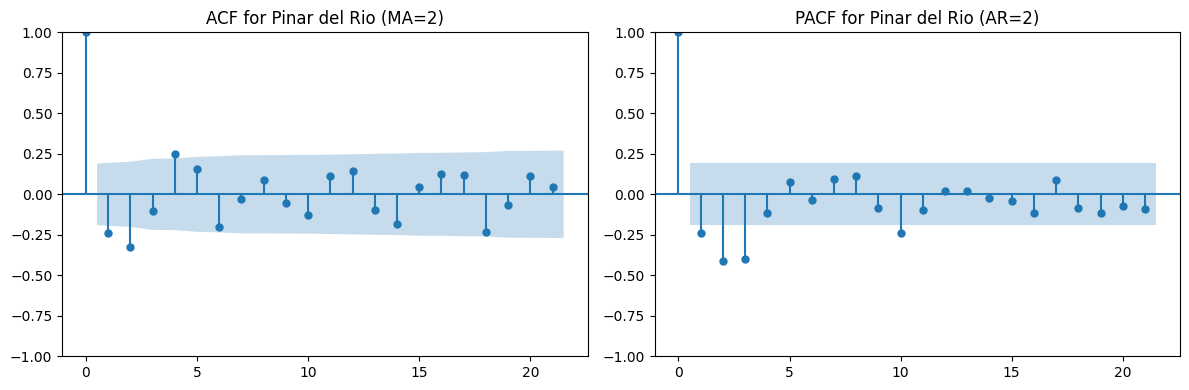

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmo

Best parameters for province 'Artemisa': (d=0 from differencing, d=1 d from AutoArima)

seasonal: True
stepwise: False
maxiter: 50
out_of_sample: 0


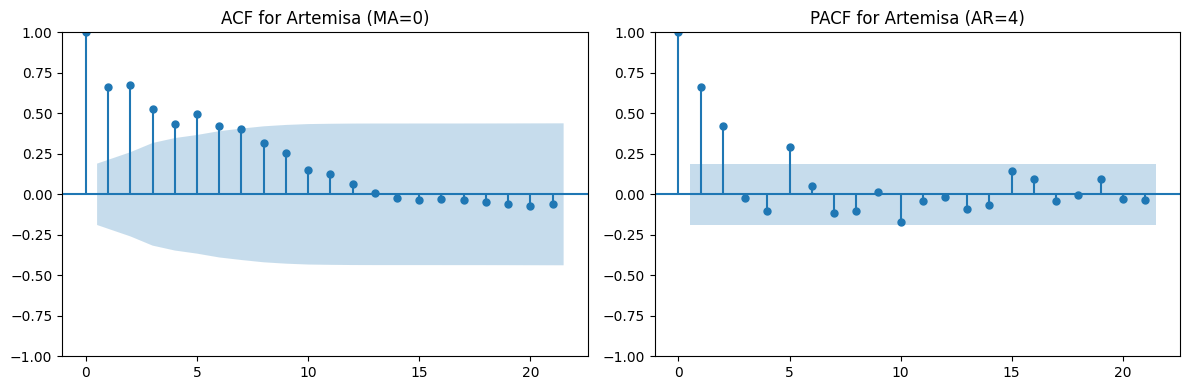

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmo

Best parameters for province 'La Habana': (d=0 from differencing, d=1 d from AutoArima)

seasonal: True
stepwise: False
maxiter: 50
out_of_sample: 0


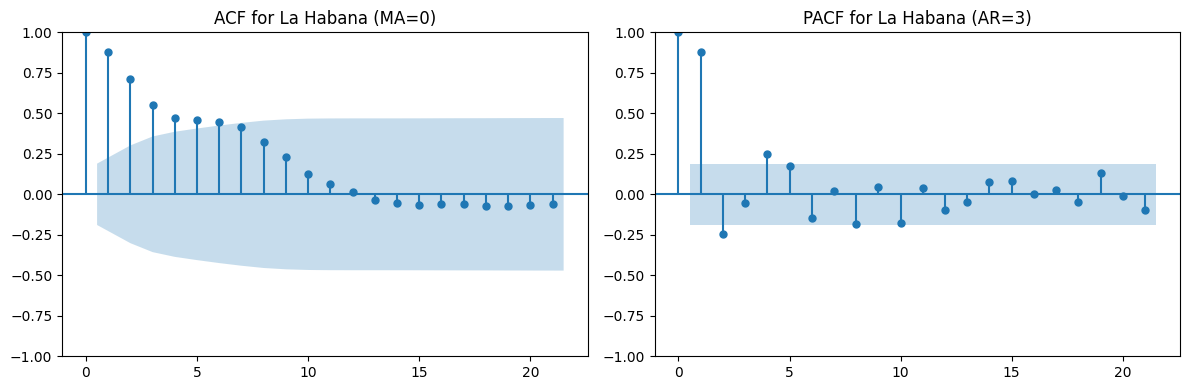

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmo

Best parameters for province 'Mayabeque': (d=0 from differencing, d=1 d from AutoArima)

seasonal: True
stepwise: False
maxiter: 50
out_of_sample: 0


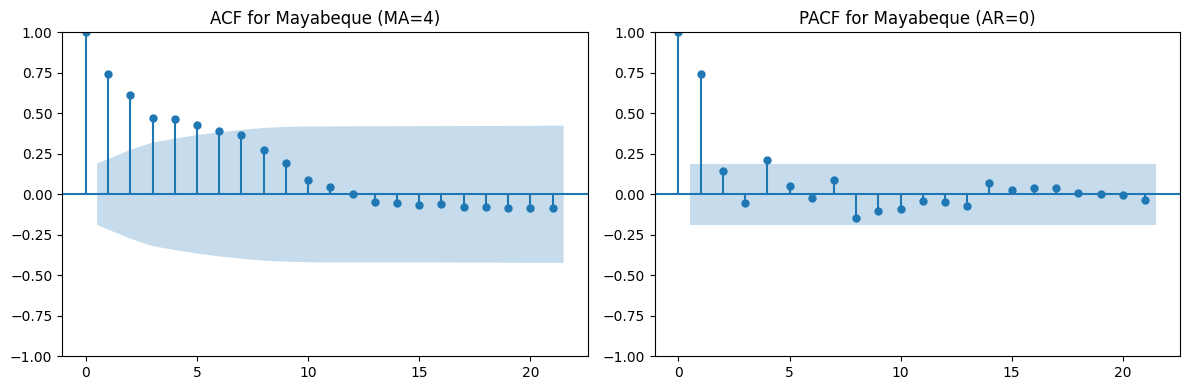

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmo

Best parameters for province 'Matanzas': (d=0 from differencing, d=1 d from AutoArima)

seasonal: True
stepwise: True
maxiter: 50
out_of_sample: 0


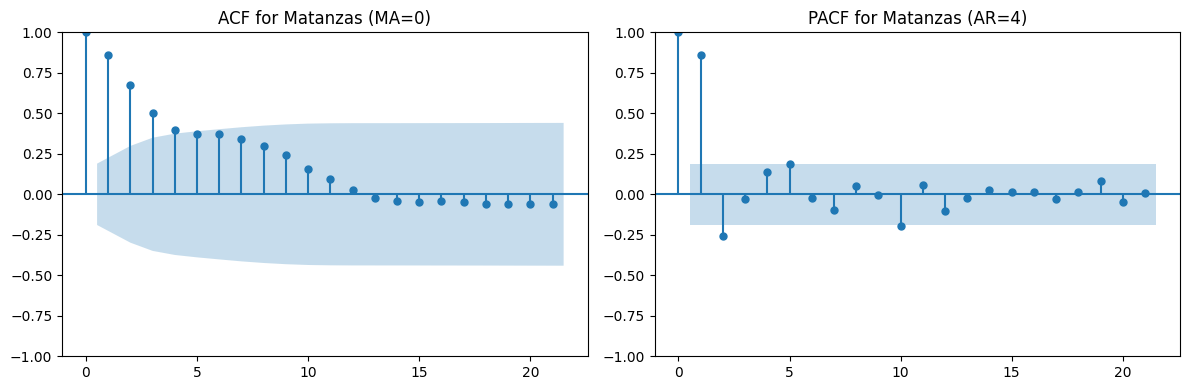

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmo

Best parameters for province 'Villa Clara': (d=1 from differencing, d=0 d from AutoArima)

seasonal: True
stepwise: True
maxiter: 50
out_of_sample: 0


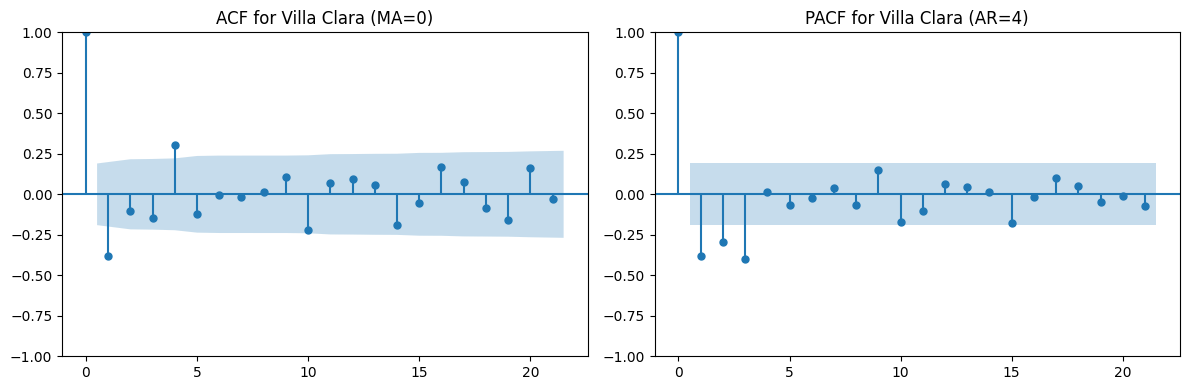

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmo

Best parameters for province 'Cienfuegos': (d=0 from differencing, d=1 d from AutoArima)

seasonal: True
stepwise: True
maxiter: 50
out_of_sample: 0


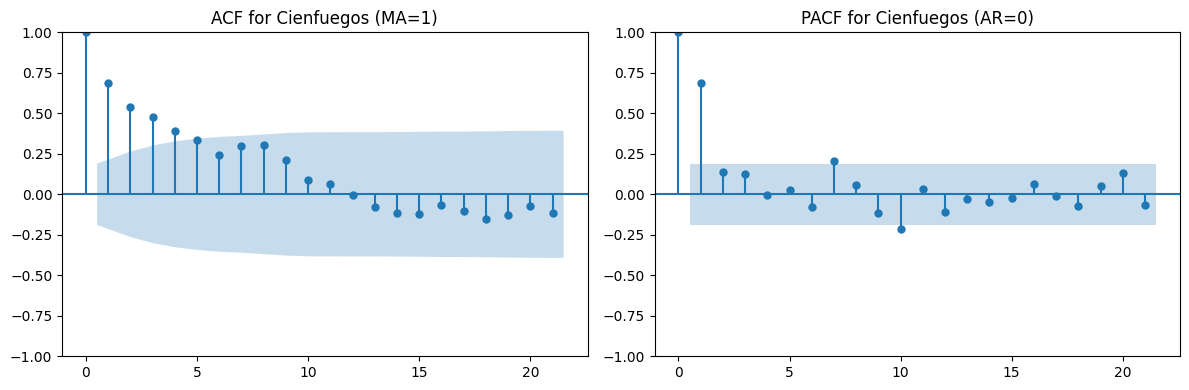

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmo

Best parameters for province 'Sancti Spiritus': (d=0 from differencing, d=0 d from AutoArima)

seasonal: False
stepwise: False
maxiter: 70
out_of_sample: 0


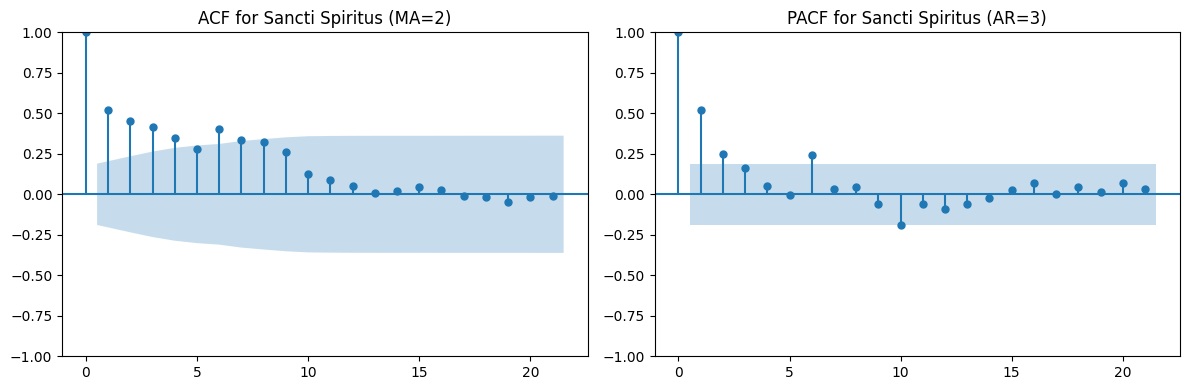

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmo

Best parameters for province 'Ciego de Ávila': (d=1 from differencing, d=0 d from AutoArima)

seasonal: True
stepwise: True
maxiter: 50
out_of_sample: 0


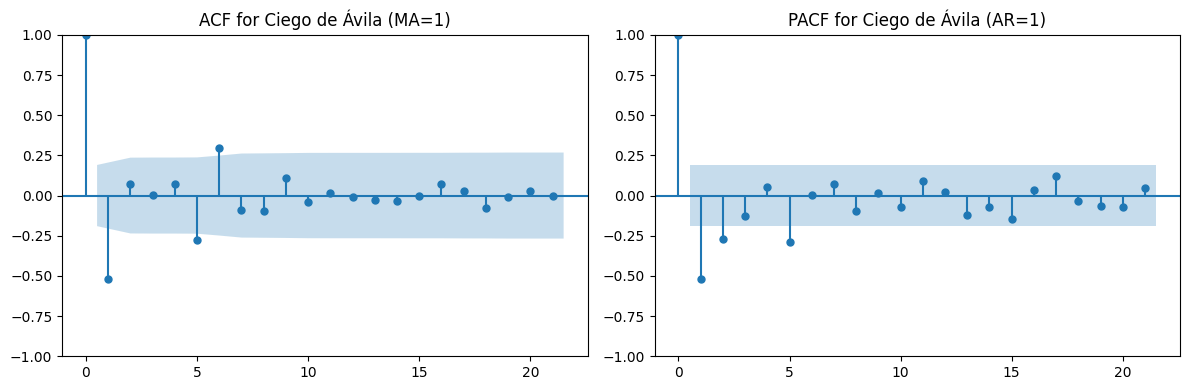

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmo

Best parameters for province 'Camagüey': (d=1 from differencing, d=0 d from AutoArima)

seasonal: True
stepwise: True
maxiter: 50
out_of_sample: 0


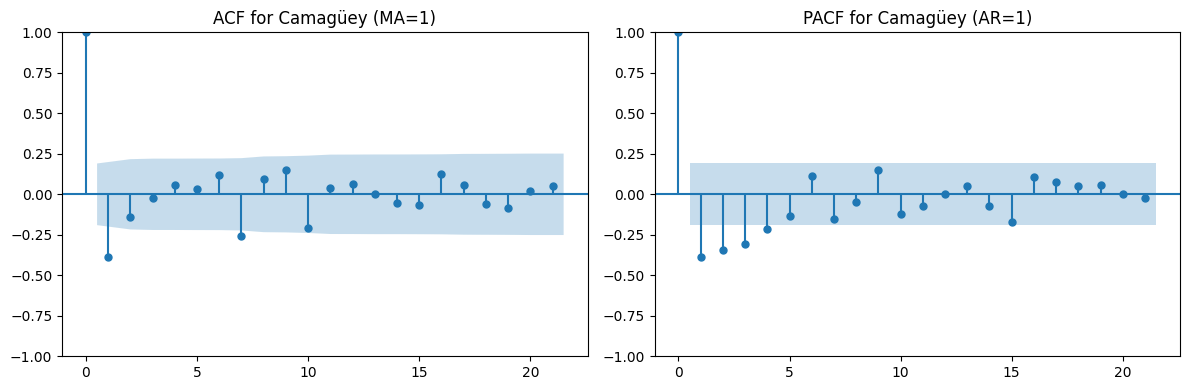

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmo

Best parameters for province 'Las Tunas': (d=1 from differencing, d=1 d from AutoArima)

seasonal: True
stepwise: True
maxiter: 50
out_of_sample: 0


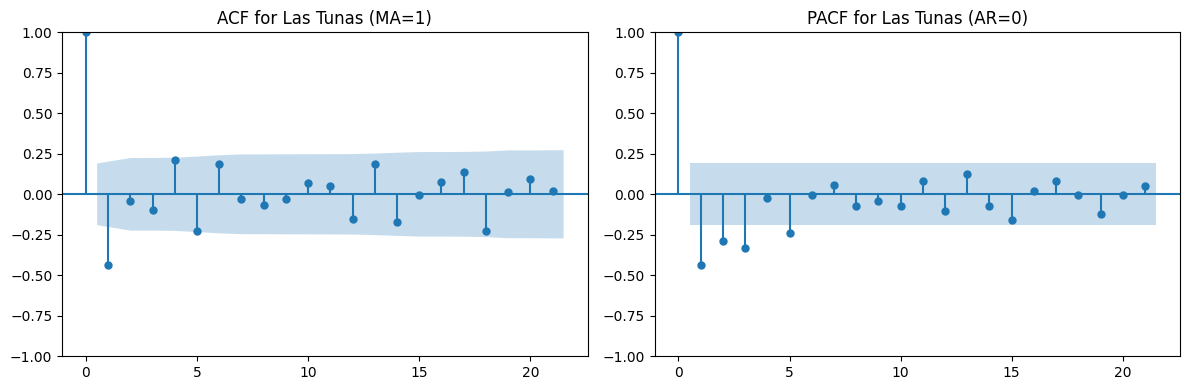

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmo

Best parameters for province 'Holguin': (d=1 from differencing, d=0 d from AutoArima)

seasonal: False
stepwise: True
maxiter: 70
out_of_sample: 0


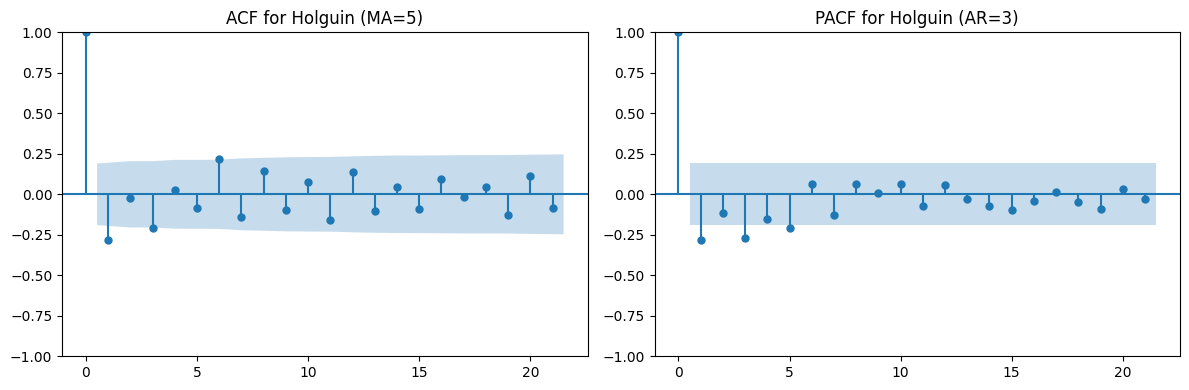

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmo

Best parameters for province 'Granma': (d=0 from differencing, d=0 d from AutoArima)

seasonal: True
stepwise: True
maxiter: 50
out_of_sample: 0


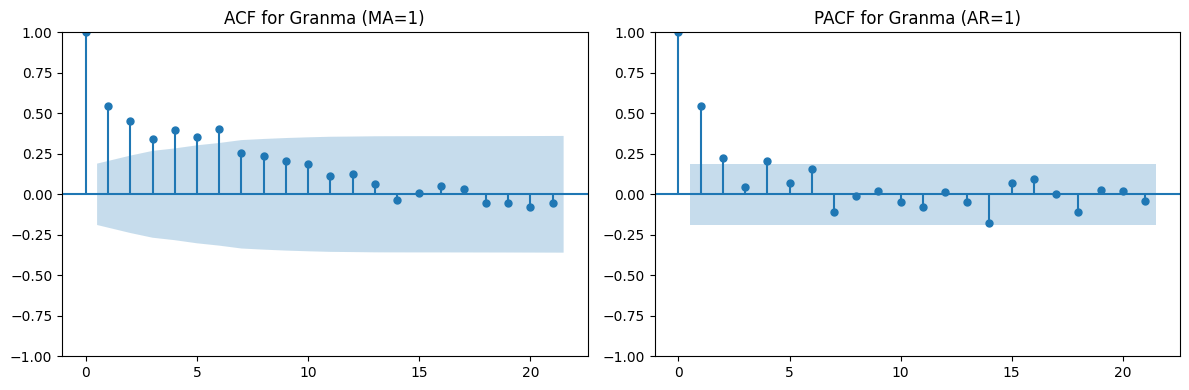

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmo

Best parameters for province 'Santiago de Cuba': (d=0 from differencing, d=1 d from AutoArima)

seasonal: True
stepwise: False
maxiter: 50
out_of_sample: 0


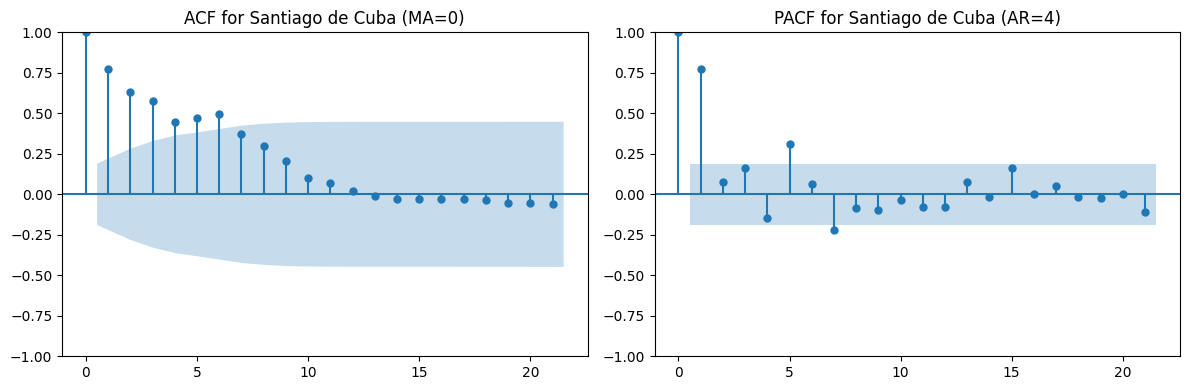

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmo

Best parameters for province 'Guantánamo': (d=0 from differencing, d=1 d from AutoArima)

seasonal: True
stepwise: False
maxiter: 50
out_of_sample: 0


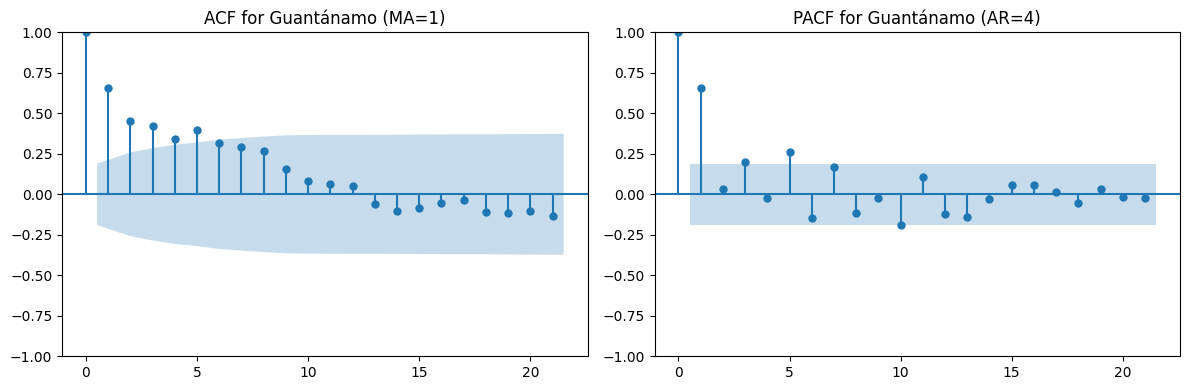

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmo

Best parameters for province 'Isla de la Juventud': (d=0 from differencing, d=1 d from AutoArima)

seasonal: True
stepwise: False
maxiter: 50
out_of_sample: 0


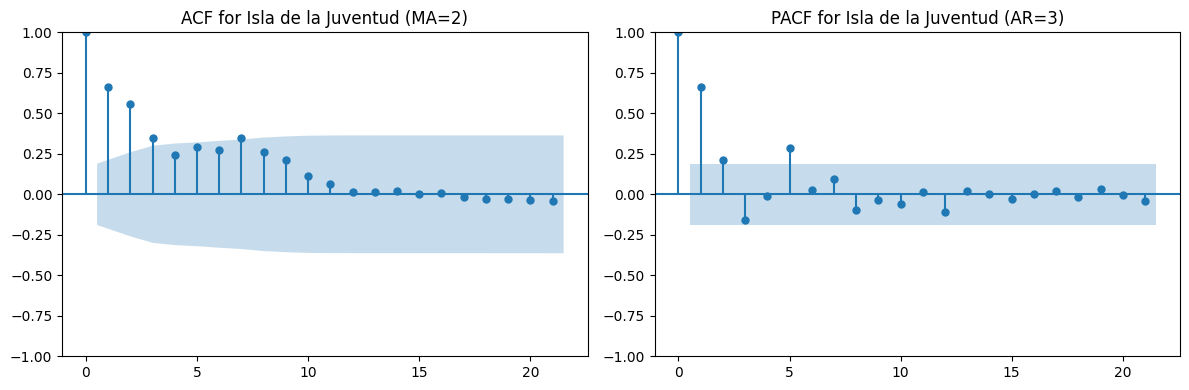

In [10]:
# Define the parameter grid
param_grid = {
    'seasonal': [True, False],
    'stepwise': [True, False],
    'maxiter': [50, 70,80,100],
    'out_of_sample': [0, 10,20]
}

models, d_from_diff = auto_arima_train(original_trainset, param_grid)

In [11]:
evaluate_model(models, d_from_diff, original_trainset, testset)

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


TypeError: ARIMA.__init__() got an unexpected keyword argument 'suppress_warnings'

Best parameters for province 'Pinar del Rio': (d=1 from differencing, d=1 d from AutoArima)



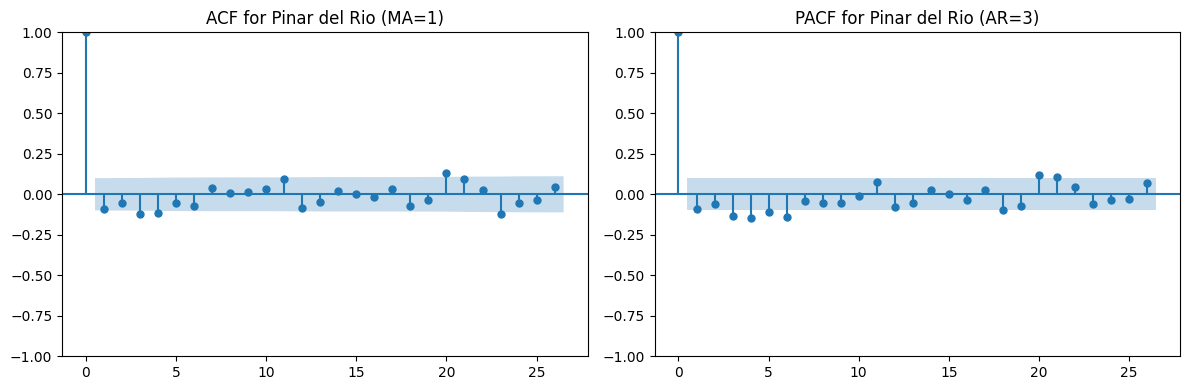

Best parameters for province 'Artemisa': (d=0 from differencing, d=1 d from AutoArima)



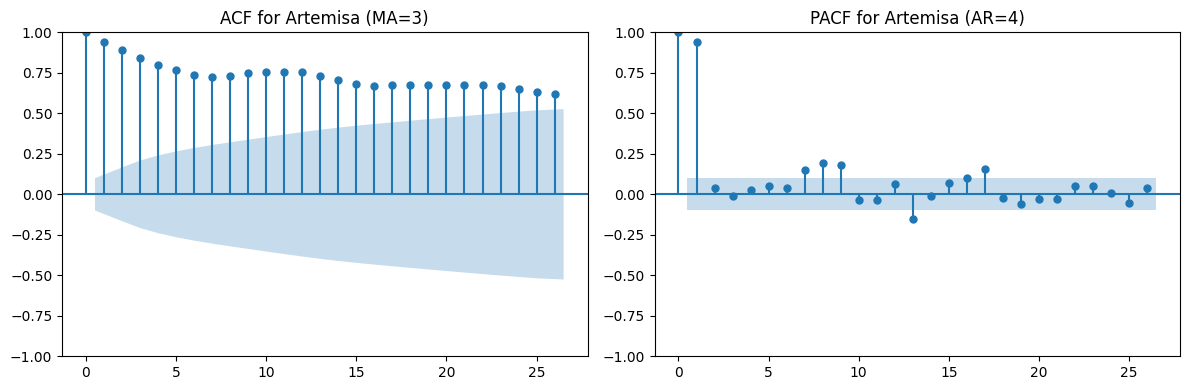

Best parameters for province 'La Habana': (d=0 from differencing, d=1 d from AutoArima)



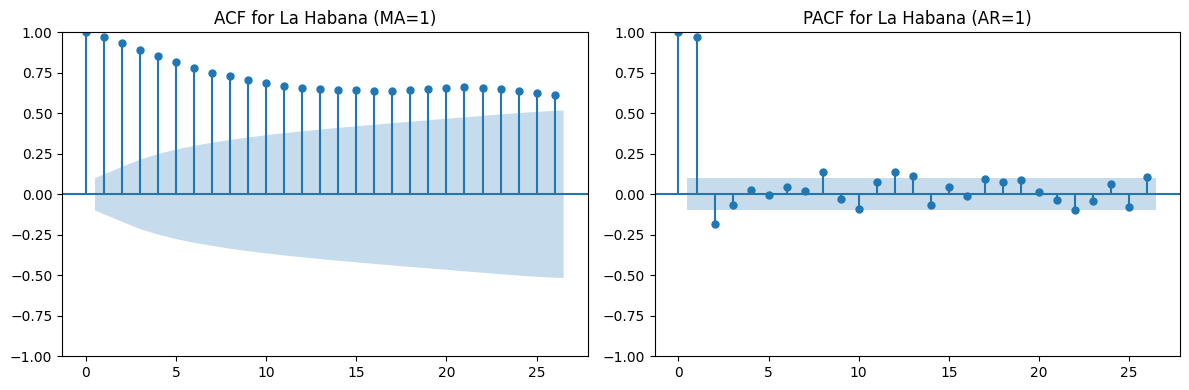

Best parameters for province 'Mayabeque': (d=0 from differencing, d=1 d from AutoArima)



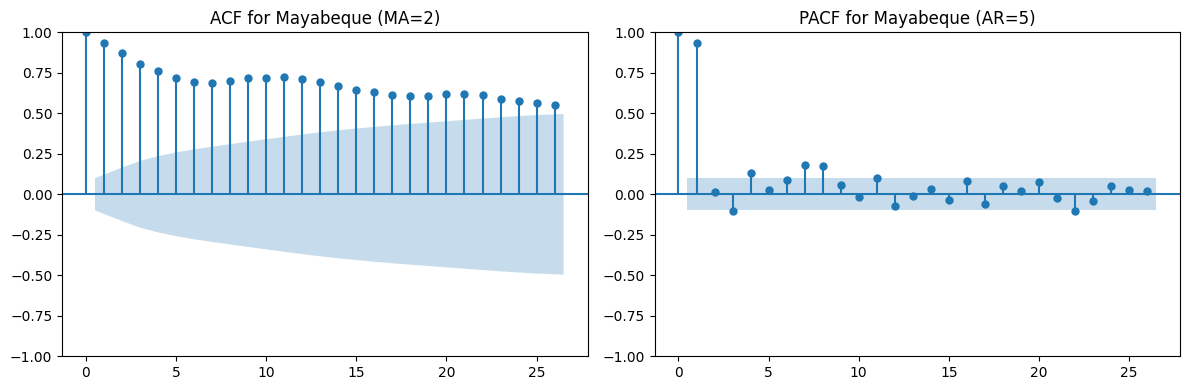

Best parameters for province 'Matanzas': (d=0 from differencing, d=1 d from AutoArima)



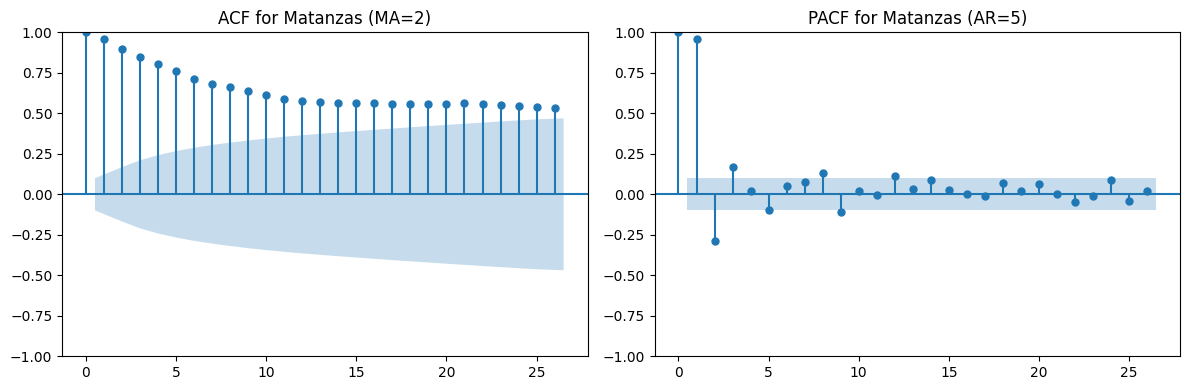

Best parameters for province 'Villa Clara': (d=1 from differencing, d=1 d from AutoArima)



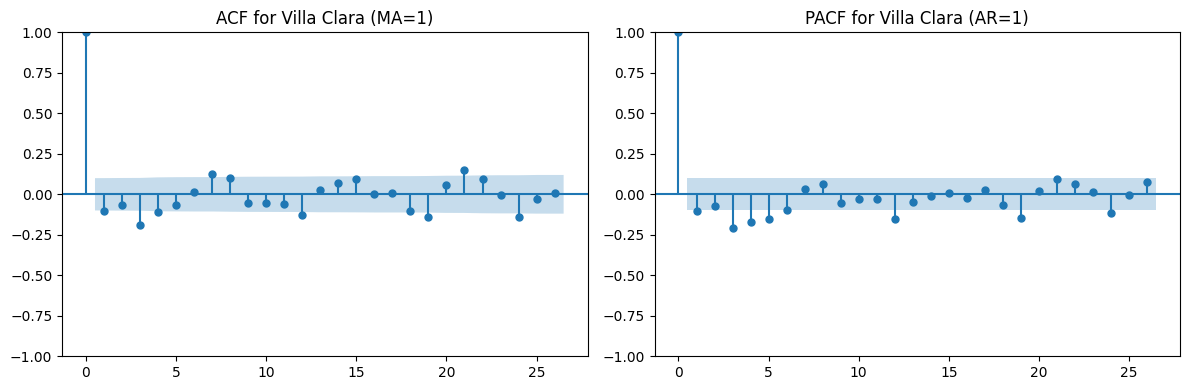

Best parameters for province 'Cienfuegos': (d=1 from differencing, d=1 d from AutoArima)



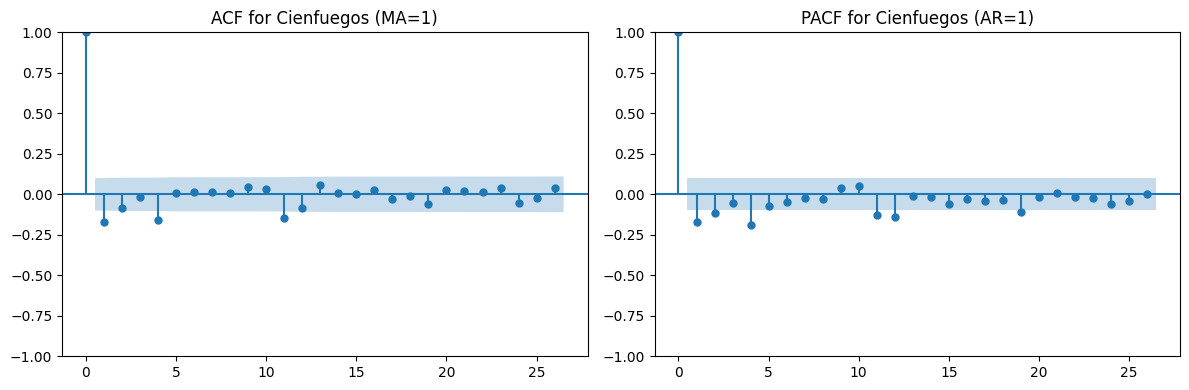

Best parameters for province 'Sancti Spiritus': (d=0 from differencing, d=1 d from AutoArima)



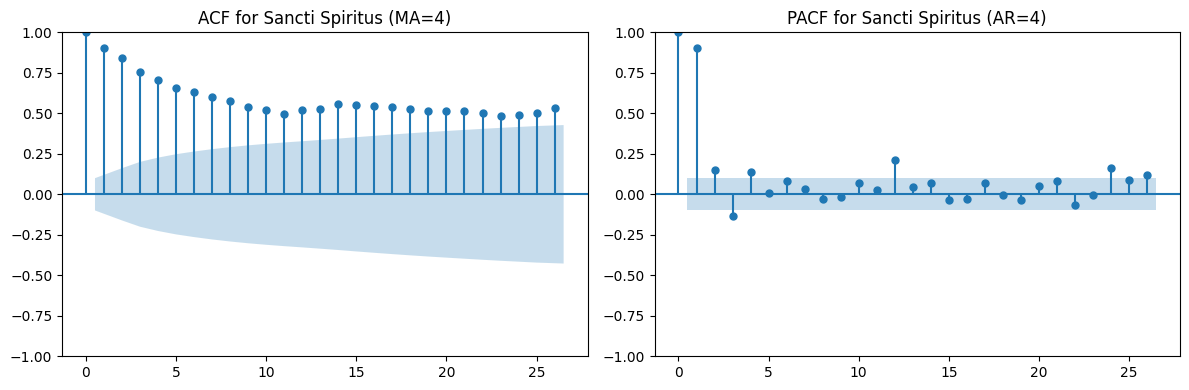

Best parameters for province 'Ciego de Ávila': (d=1 from differencing, d=1 d from AutoArima)



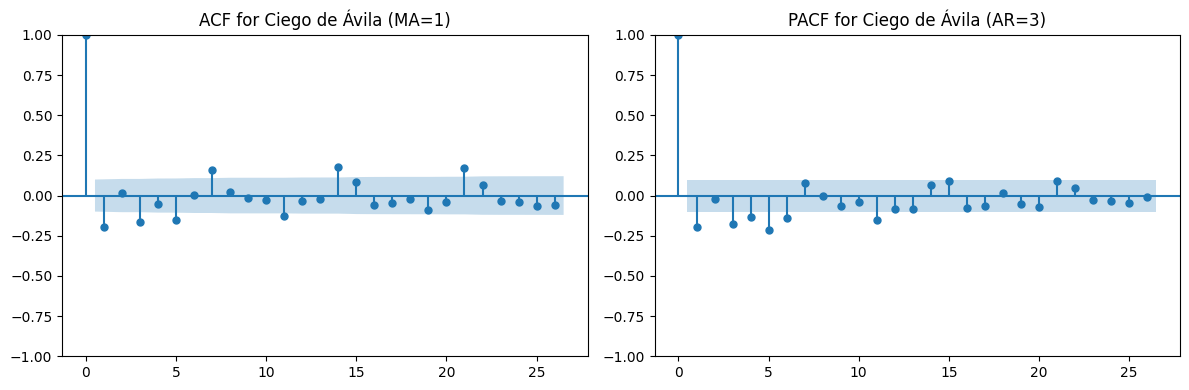

Best parameters for province 'Camagüey': (d=1 from differencing, d=1 d from AutoArima)



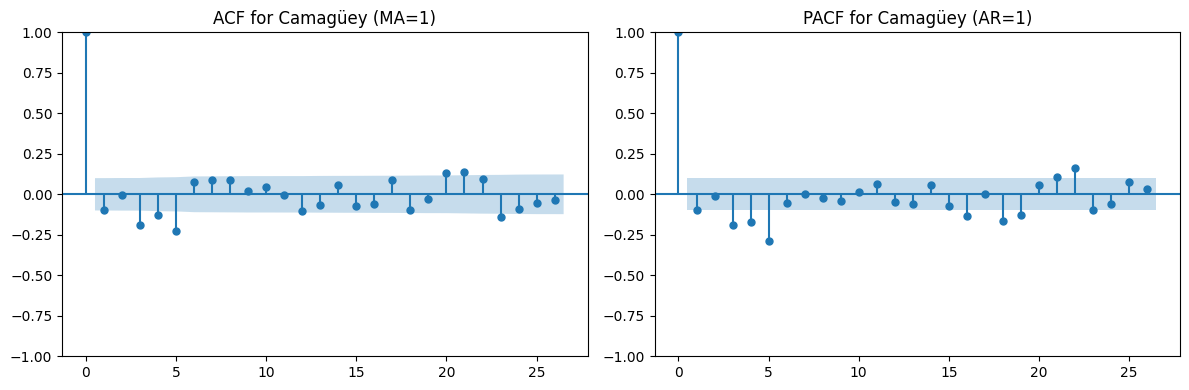

Best parameters for province 'Las Tunas': (d=1 from differencing, d=1 d from AutoArima)



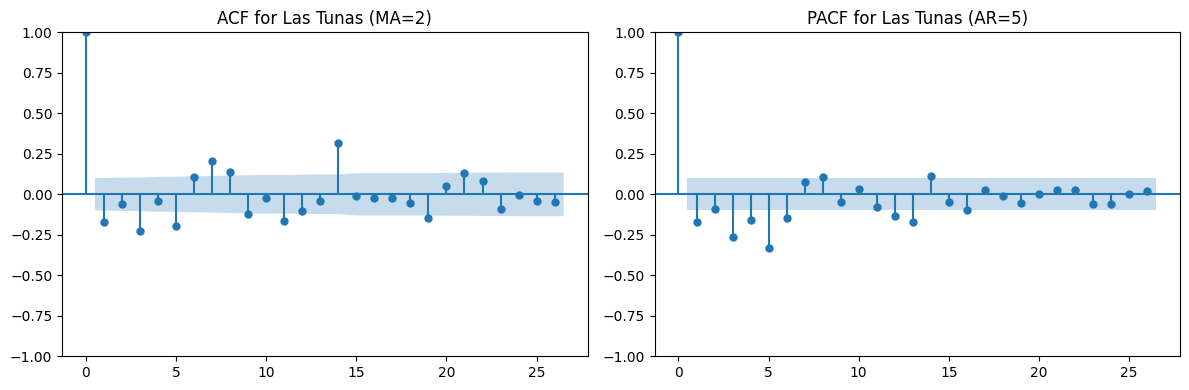

Best parameters for province 'Holguin': (d=1 from differencing, d=1 d from AutoArima)



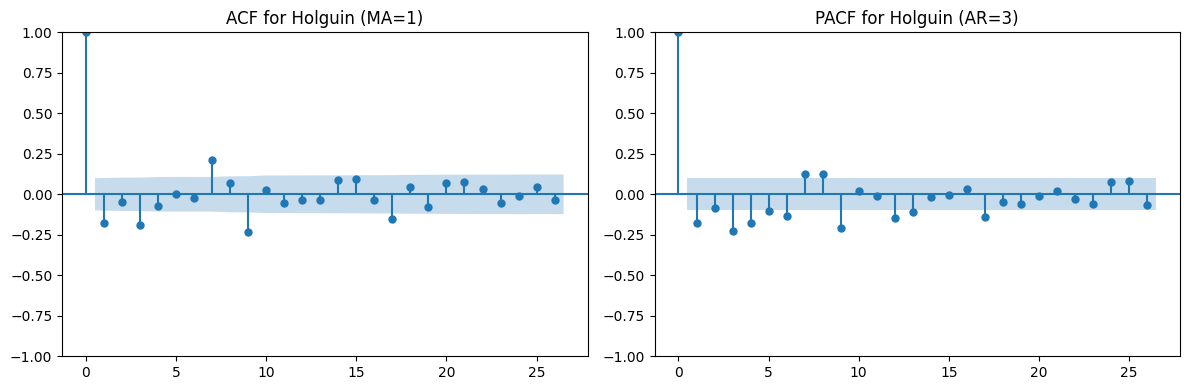

Best parameters for province 'Granma': (d=1 from differencing, d=1 d from AutoArima)



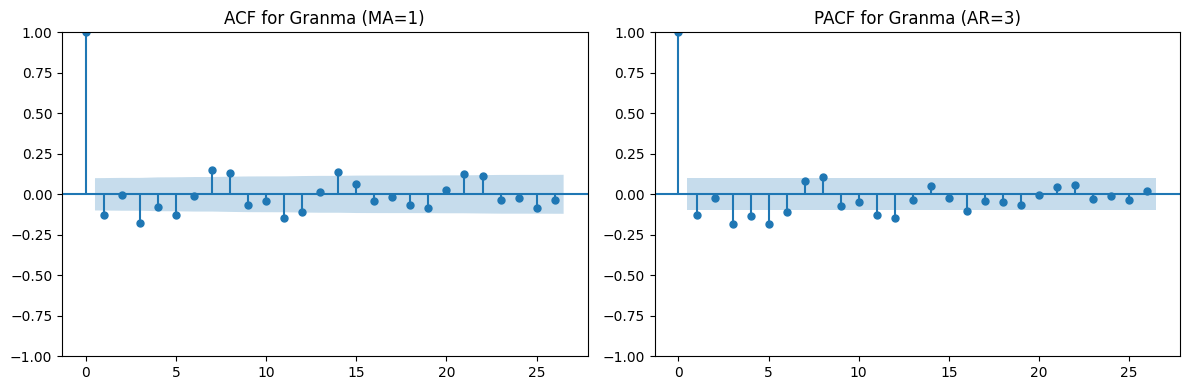

Best parameters for province 'Santiago de Cuba': (d=1 from differencing, d=1 d from AutoArima)



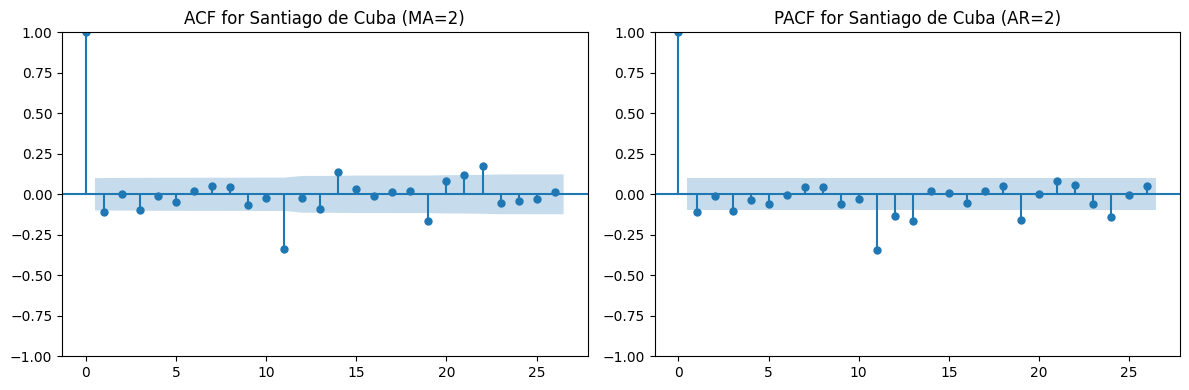

Best parameters for province 'Guantánamo': (d=0 from differencing, d=1 d from AutoArima)



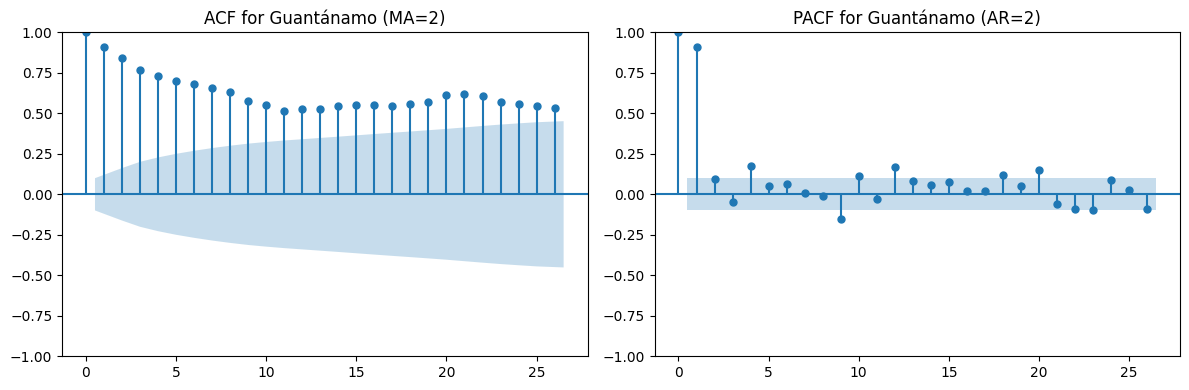

Best parameters for province 'Isla de la Juventud': (d=0 from differencing, d=1 d from AutoArima)



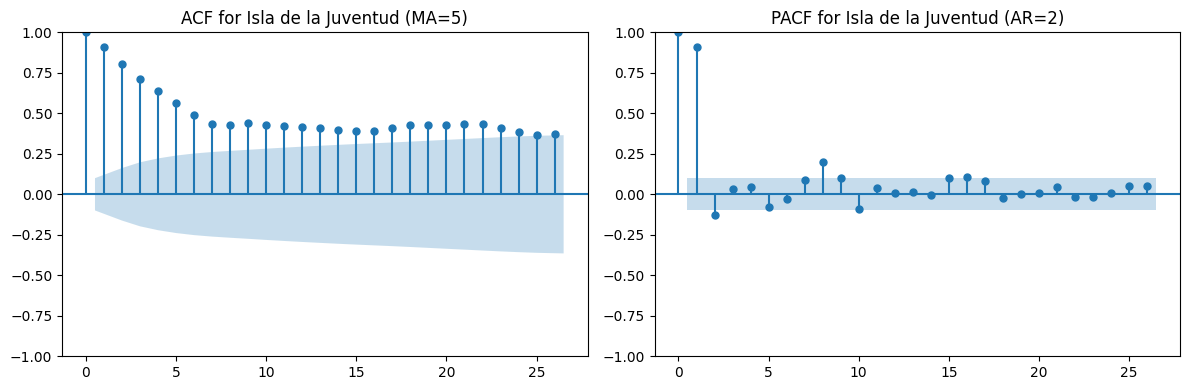

In [41]:
models, d_from_diff = auto_arima_train(aug_trainset)

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre

 AutoArima Predictions for Pinar del Rio: incomes. d = 1
107     84.679597
108     86.377032
109     97.678964
110    103.848278
111    100.304432
112     93.905793
113     92.133540
114     95.251215
115     98.445525
116     98.431956
117     96.295332
118     94.924302
119     95.462030
120     96.722653
121     97.178701
122     96.633516
123     95.977582
124     95.917078
125     96.314941
126     96.612230
127     96.539219
128     96.294025
129     96.184286
130     96.276739
131     96.409556
132     96.433758
133     96.360915
134     96.297743
135     96.305464
136     96.352531
137     96.377790
138     96.362752
139     96.336212
140     96.329087
dtype: float64

Arima Predictions for Pinar del Rio: incomes. d = 1
2023-10-11    99.835449
2023-10-12    99.050338
2023-10-13    98.077559
2023-10-14    97.200643
2023-10-15    96.559885
2023-10-16    96.185539
2023-10-17    96.039405
2023-10-18    96.052538
2023-10-19    96.152930
2023-10-20    96.281785
2023-10-21    96.399981

C:\Users\Melissa\AppData\Local\Temp\ipykernel_19500\1194971014.py:84: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  auto_mape = np.mean(np.abs((curr_test - auto_predictions) / curr_test)) * 100


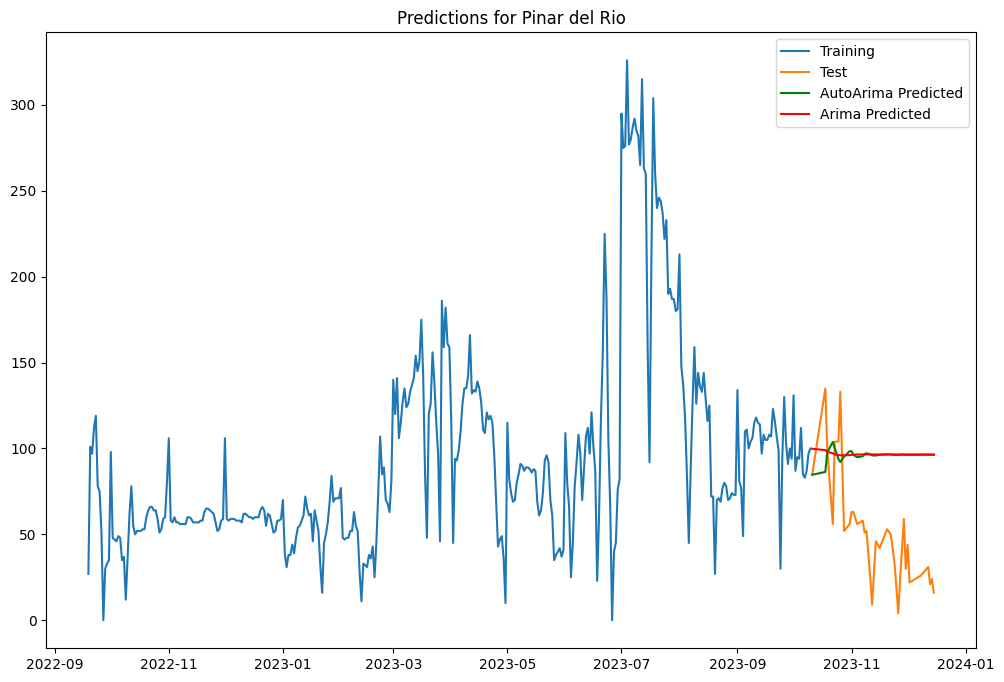

                               SARIMAX Results                                
Dep. Variable:          Pinar del Rio   No. Observations:                  387
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1819.707
Date:                Thu, 30 Jan 2025   AIC                           3649.415
Time:                        12:50:19   BIC                           3669.194
Sample:                    09-19-2022   HQIC                          3657.258
                         - 10-10-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3574      0.173      7.846      0.000       1.018       1.697
ar.L2         -0.5650      0.104     -5.420      0.000      -0.769      -0.361
ma.L1         -1.5031      0.183     -8.205      0.0

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre

 AutoArima Predictions for Artemisa: incomes. d = 1
107    32.129605
108    22.410860
109    27.027756
110    26.943056
111    19.548613
112    22.922308
113    15.957827
114    18.024867
115    15.400073
116    13.197717
117    12.992311
118     9.202430
119     9.219587
120     6.502331
121     5.236693
122     3.757336
123     1.480774
124     0.437874
125    -1.814961
126    -3.144724
127    -4.940759
128    -6.710806
129    -8.210660
130   -10.124902
131   -11.628704
132   -13.429315
133   -15.084601
134   -16.744166
135   -18.500498
136   -20.115996
137   -21.866398
138   -23.519593
139   -25.218626
140   -26.919282
dtype: float64

Arima Predictions for Artemisa: incomes. d = 0
2023-10-11    21.866124
2023-10-12    22.461671
2023-10-13    23.917539
2023-10-14    24.899715
2023-10-15    25.926945
2023-10-16    26.907810
2023-10-17    27.872973
2023-10-18    28.813134
2023-10-19    29.731087
2023-10-20    30.626717
2023-10-21    31.500758
2023-10-22    32.353683
2023-10-23    33.18

C:\Users\Melissa\AppData\Local\Temp\ipykernel_19500\1194971014.py:84: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  auto_mape = np.mean(np.abs((curr_test - auto_predictions) / curr_test)) * 100


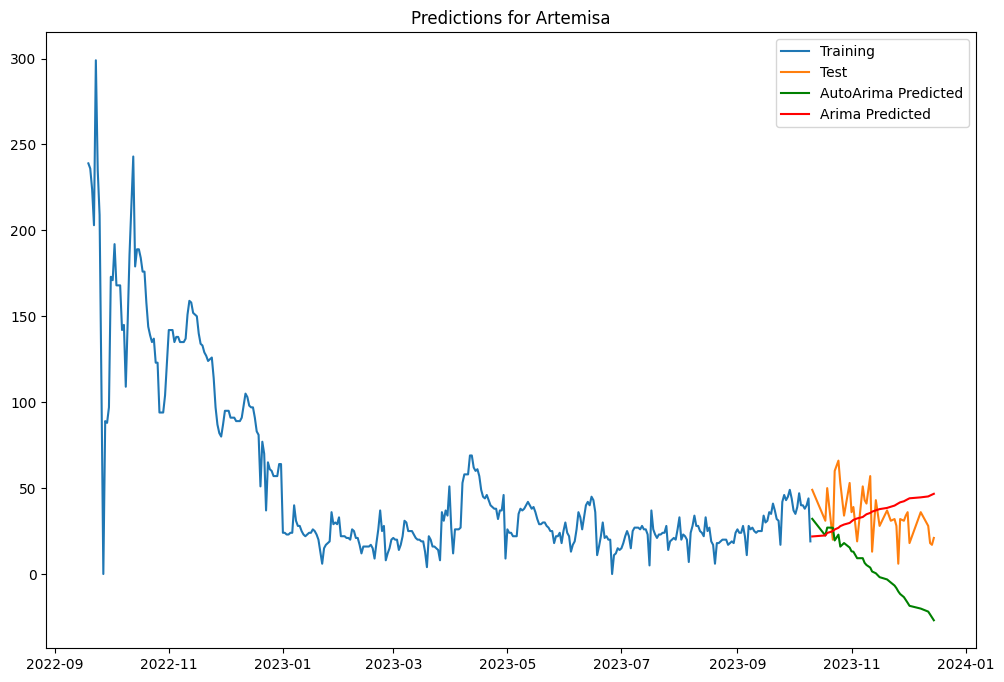

                               SARIMAX Results                                
Dep. Variable:               Artemisa   No. Observations:                  387
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -1595.883
Date:                Thu, 30 Jan 2025   AIC                           3203.765
Time:                        12:50:21   BIC                           3227.516
Sample:                    09-19-2022   HQIC                          3213.183
                         - 10-10-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         66.8228     35.487      1.883      0.060      -2.731     136.376
ar.L1          0.9099      0.022     41.457      0.000       0.867       0.953
ar.L2          0.0774      0.045      1.738      0.0

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre

 AutoArima Predictions for La Habana: incomes. d = 1
107     58.356336
108     68.392282
109     66.560109
110     61.684843
111     48.327117
112     41.019319
113     36.014414
114     34.580216
115     29.988780
116     23.927921
117     16.420232
118     10.586685
119      5.611167
120      1.185332
121     -4.136304
122     -9.930831
123    -15.910065
124    -21.408357
125    -26.657235
126    -31.860792
127    -37.322292
128    -42.910428
129    -48.496645
130    -53.945119
131    -59.331633
132    -64.731923
133    -70.205270
134    -75.707736
135    -81.196664
136    -86.647179
137    -92.084665
138    -97.532346
139   -103.000016
140   -108.473133
dtype: float64

Arima Predictions for La Habana: incomes. d = 0
2023-10-11     65.764591
2023-10-12     65.340144
2023-10-13     66.391535
2023-10-14     67.714565
2023-10-15     69.236689
2023-10-16     70.775675
2023-10-17     72.317742
2023-10-18     73.835736
2023-10-19     75.327625
2023-10-20     76.789820
2023-10-21     78.222

C:\Users\Melissa\AppData\Local\Temp\ipykernel_19500\1194971014.py:84: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  auto_mape = np.mean(np.abs((curr_test - auto_predictions) / curr_test)) * 100


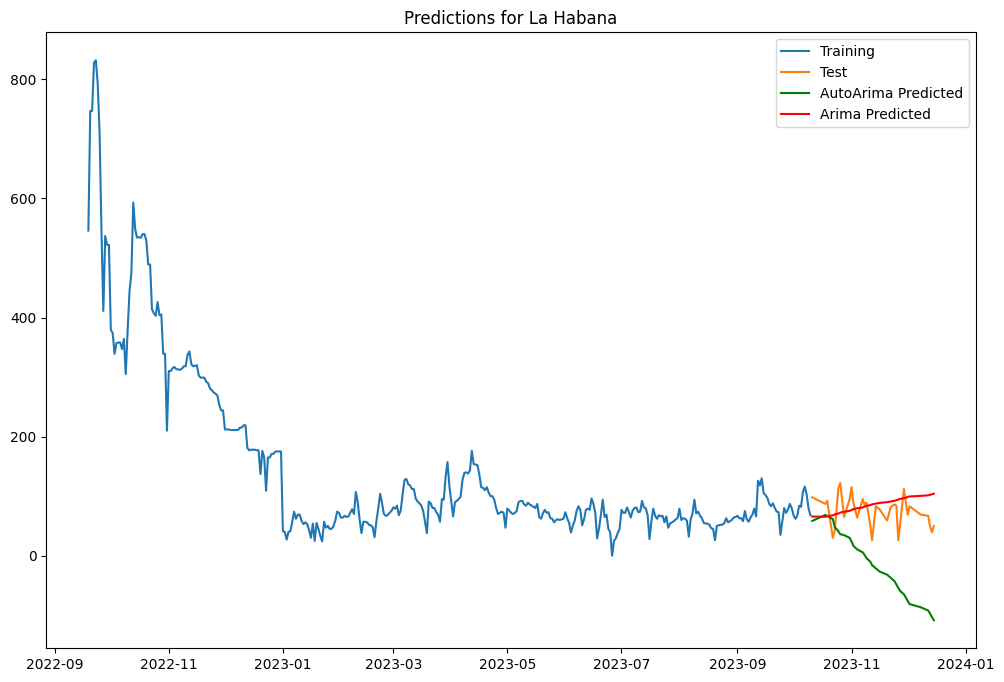

                               SARIMAX Results                                
Dep. Variable:              La Habana   No. Observations:                  387
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -1836.364
Date:                Thu, 30 Jan 2025   AIC                           3682.728
Time:                        12:50:22   BIC                           3702.520
Sample:                    09-19-2022   HQIC                          3690.576
                         - 10-10-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        145.7669     87.363      1.669      0.095     -25.462     316.996
ar.L1          0.9980      0.032     30.787      0.000       0.934       1.062
ar.L2          0.1323      0.054      2.445      0.0

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre

 AutoArima Predictions for Mayabeque: incomes. d = 1
107    16.207237
108     7.645227
109    22.381800
110    12.777900
111    10.712600
112     8.647301
113     6.582002
114     4.516703
115     2.451403
116     0.386104
117    -1.679195
118    -3.744494
119    -5.809794
120    -7.875093
121    -9.940392
122   -12.005691
123   -14.070991
124   -16.136290
125   -18.201589
126   -20.266888
127   -22.332188
128   -24.397487
129   -26.462786
130   -28.528085
131   -30.593385
132   -32.658684
133   -34.723983
134   -36.789282
135   -38.854582
136   -40.919881
137   -42.985180
138   -45.050479
139   -47.115779
140   -49.181078
dtype: float64

Arima Predictions for Mayabeque: incomes. d = 0
2023-10-11    13.775907
2023-10-12     5.061462
2023-10-13    17.291479
2023-10-14    25.741014
2023-10-15    47.119413
2023-10-16    47.119413
2023-10-17    47.119413
2023-10-18    47.119413
2023-10-19    47.119413
2023-10-20    47.119413
2023-10-21    47.119413
2023-10-22    47.119413
2023-10-23    47.

C:\Users\Melissa\AppData\Local\Temp\ipykernel_19500\1194971014.py:84: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  auto_mape = np.mean(np.abs((curr_test - auto_predictions) / curr_test)) * 100


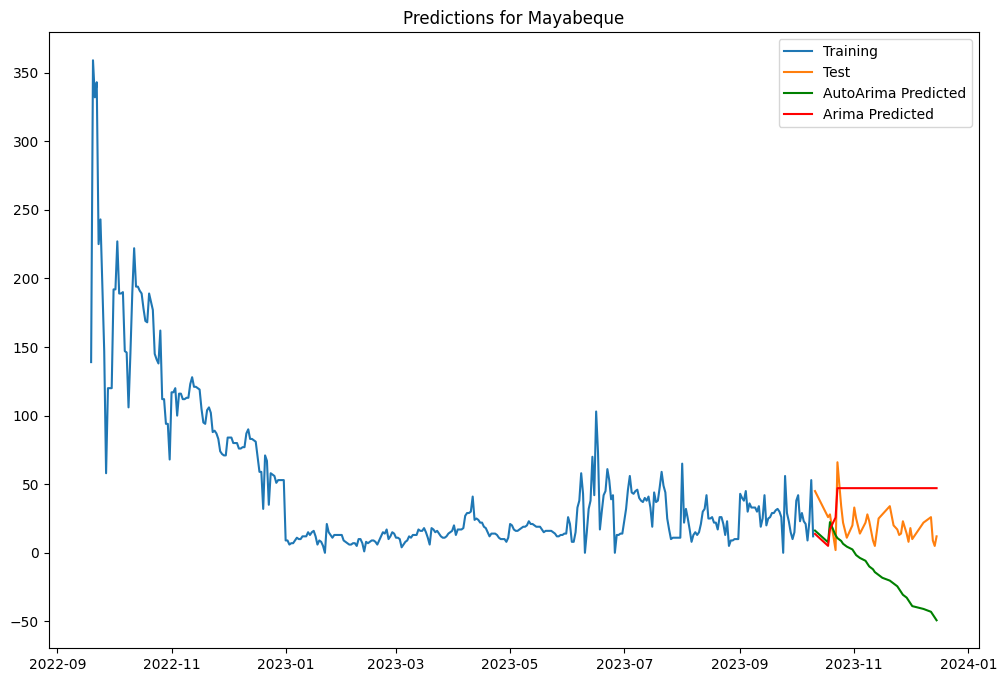

                               SARIMAX Results                                
Dep. Variable:              Mayabeque   No. Observations:                  387
Model:                 ARIMA(0, 0, 4)   Log Likelihood               -1751.716
Date:                Thu, 30 Jan 2025   AIC                           3515.431
Time:                        12:50:23   BIC                           3539.182
Sample:                    09-19-2022   HQIC                          3524.849
                         - 10-10-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.1194      6.029      7.815      0.000      35.302      58.936
ma.L1          1.0893      0.031     35.330      0.000       1.029       1.150
ma.L2          1.1196      0.033     33.561      0.0

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre

 AutoArima Predictions for Matanzas: incomes. d = 1
107    16.857970
108    15.767222
109    15.076501
110    16.721493
111    16.454454
112    13.624802
113     9.445728
114     4.994994
115     2.330147
116     1.022309
117     0.541003
118    -0.571812
119    -2.796478
120    -5.929350
121    -9.161654
122   -11.763447
123   -13.590740
124   -14.999632
125   -16.588176
126   -18.697682
127   -21.278262
128   -23.969223
129   -26.409802
130   -28.471242
131   -30.298546
132   -32.164953
133   -34.264870
134   -36.603221
135   -39.025911
136   -41.352952
137   -43.501106
138   -45.520951
139   -47.538061
140   -49.656052
dtype: float64

Arima Predictions for Matanzas: incomes. d = 0
2023-10-11    27.722441
2023-10-12    28.627227
2023-10-13    28.786888
2023-10-14    28.545360
2023-10-15    28.563784
2023-10-16    28.691930
2023-10-17    28.822467
2023-10-18    28.904316
2023-10-19    28.978233
2023-10-20    29.058752
2023-10-21    29.145177
2023-10-22    29.230452
2023-10-23    29.31

C:\Users\Melissa\AppData\Local\Temp\ipykernel_19500\1194971014.py:84: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  auto_mape = np.mean(np.abs((curr_test - auto_predictions) / curr_test)) * 100


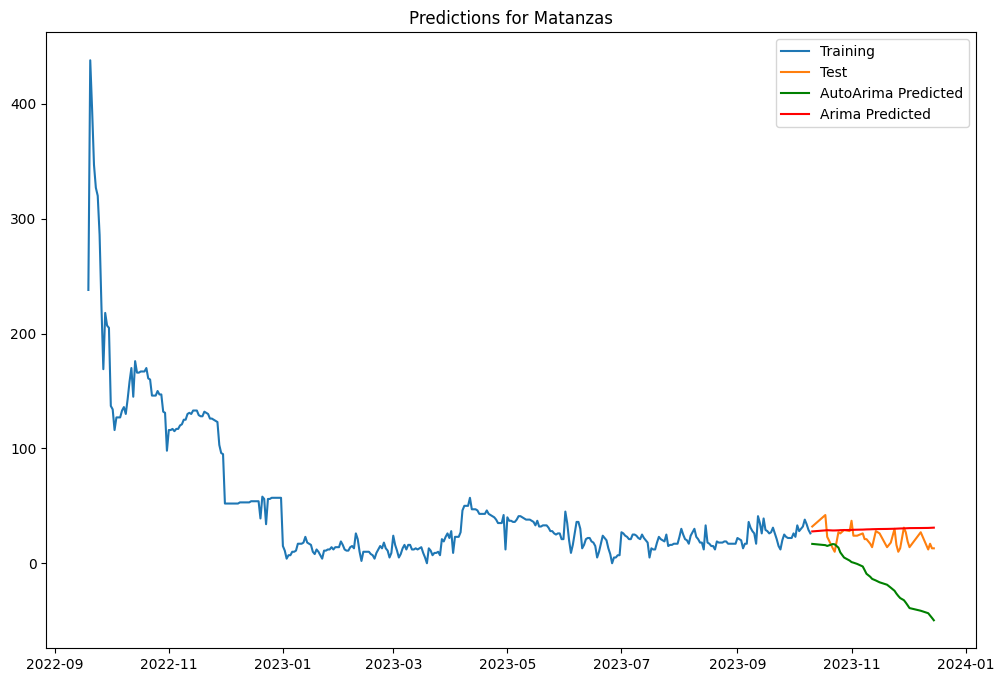

                               SARIMAX Results                                
Dep. Variable:               Matanzas   No. Observations:                  387
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -1579.748
Date:                Thu, 30 Jan 2025   AIC                           3171.496
Time:                        12:50:24   BIC                           3195.247
Sample:                    09-19-2022   HQIC                          3180.914
                         - 10-10-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.0559    117.644      0.425      0.670    -180.522     280.634
ar.L1          0.8496      0.039     21.988      0.000       0.774       0.925
ar.L2          0.0179      0.043      0.412      0.6

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre

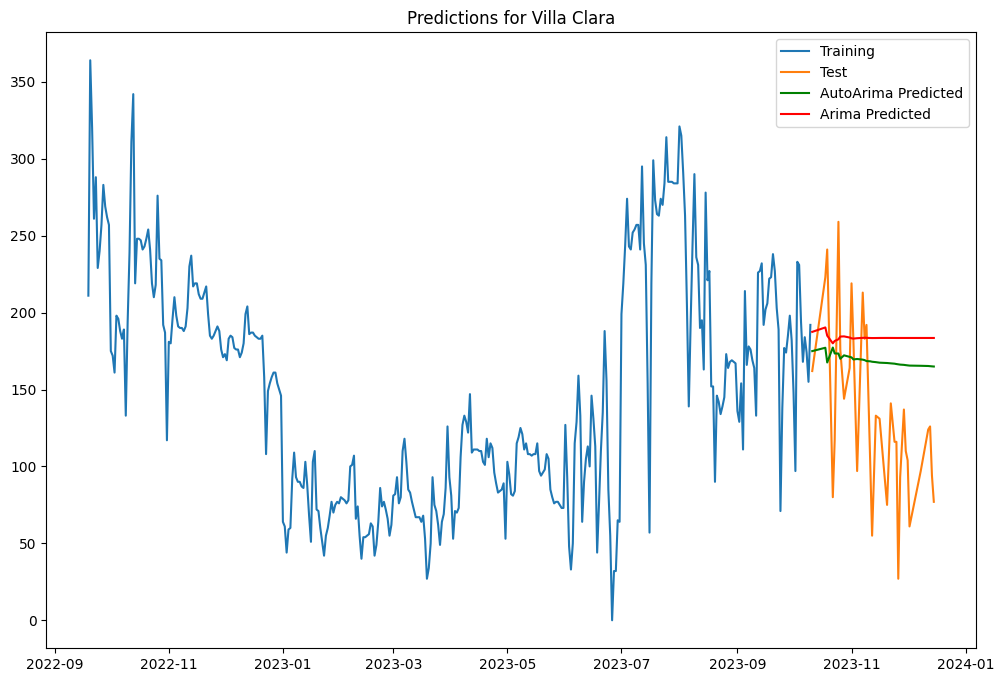

                               SARIMAX Results                                
Dep. Variable:            Villa Clara   No. Observations:                  387
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1866.068
Date:                Thu, 30 Jan 2025   AIC                           3742.136
Time:                        12:50:25   BIC                           3761.915
Sample:                    09-19-2022   HQIC                          3749.980
                         - 10-10-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1670      0.033     -5.072      0.000      -0.232      -0.102
ar.L2         -0.1128      0.037     -3.033      0.002      -0.186      -0.040
ar.L3         -0.2370      0.041     -5.777      0.0

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre

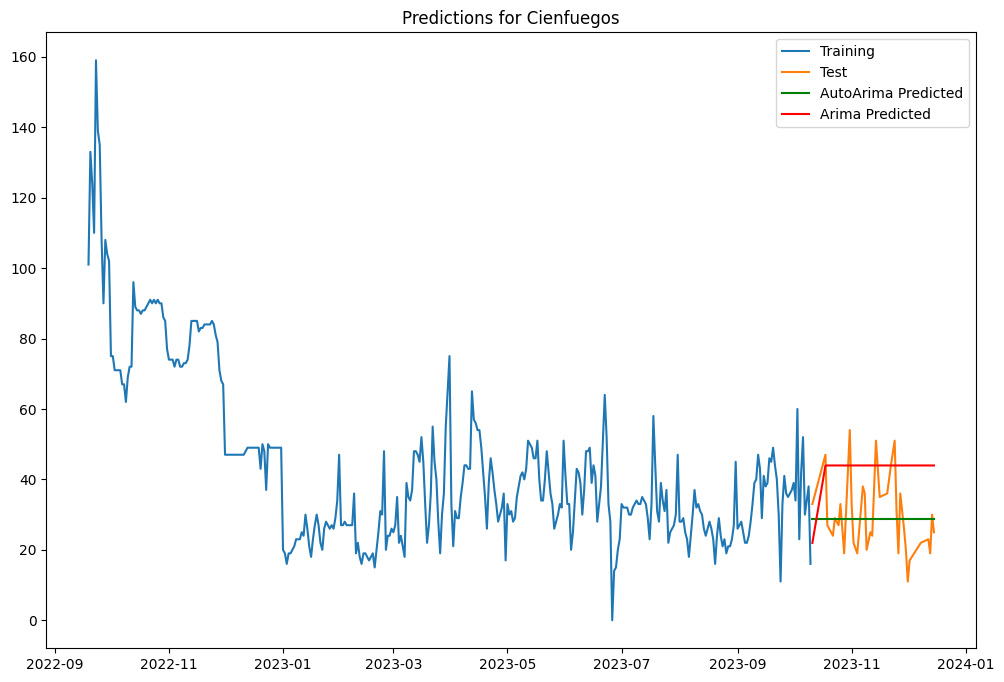

                               SARIMAX Results                                
Dep. Variable:             Cienfuegos   No. Observations:                  387
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1606.669
Date:                Thu, 30 Jan 2025   AIC                           3219.338
Time:                        12:50:25   BIC                           3231.214
Sample:                    09-19-2022   HQIC                          3224.047
                         - 10-10-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.9549      1.725     25.486      0.000      40.575      47.335
ma.L1          0.7821      0.034     22.891      0.000       0.715       0.849
sigma2       235.7750     12.231     19.276      0.0

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre

 AutoArima Predictions for Sancti Spiritus: incomes. d = 0
107    64.478685
108    65.141238
109    64.801112
110    64.034130
111    63.055375
112    61.962739
113    60.808869
114    59.625100
115    58.431007
116    57.239035
117    56.057109
118    54.890235
119    53.741516
120    52.612811
121    51.505170
122    50.419115
123    49.354823
124    48.312251
125    47.291212
126    46.291429
127    45.312573
128    44.354275
129    43.416154
130    42.497815
131    41.598861
132    40.718897
133    39.857531
134    39.014375
135    38.189048
136    37.381175
137    36.590390
138    35.816331
139    35.058646
140    34.316988
dtype: float64

Arima Predictions for Sancti Spiritus: incomes. d = 0
2023-10-11    59.491094
2023-10-12    68.762535
2023-10-13    65.468722
2023-10-14    73.205972
2023-10-15    68.929363
2023-10-16    75.743461
2023-10-17    70.943996
2023-10-18    77.186612
2023-10-19    72.127722
2023-10-20    78.001550
2023-10-21    72.833819
2023-10-22    78.455981
2023-

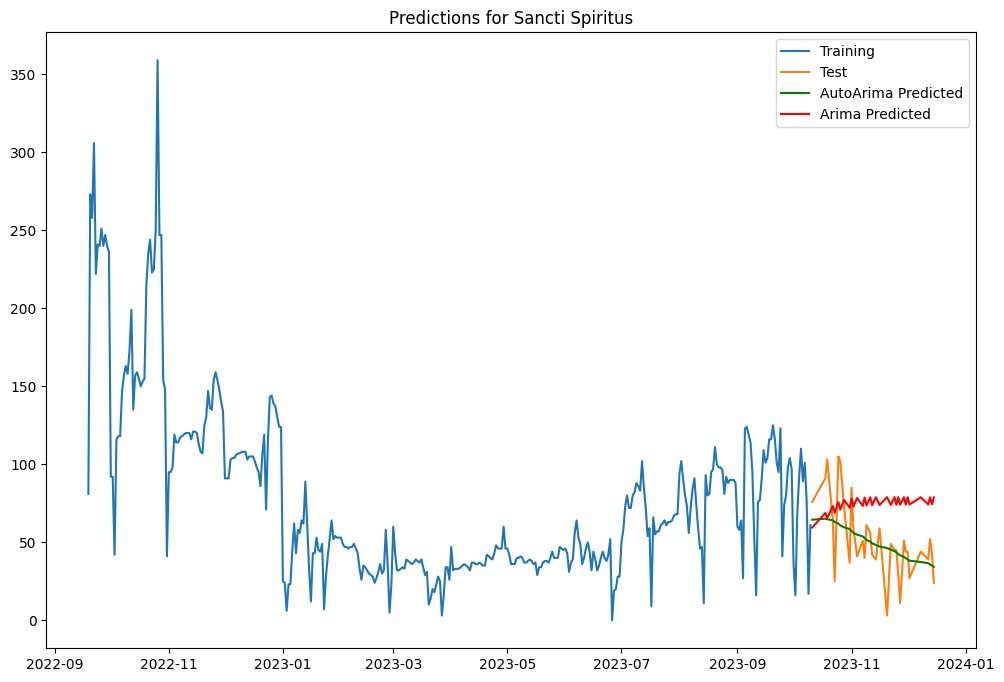

                               SARIMAX Results                                
Dep. Variable:        Sancti Spiritus   No. Observations:                  387
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -1762.564
Date:                Thu, 30 Jan 2025   AIC                           3539.128
Time:                        12:50:28   BIC                           3566.837
Sample:                    09-19-2022   HQIC                          3550.115
                         - 10-10-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         77.9780     65.883      1.184      0.237     -51.150     207.106
ar.L1          0.7619      0.042     18.079      0.000       0.679       0.844
ar.L2          0.9835      0.009    107.049      0.0

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre

 AutoArima Predictions for Ciego de Ávila: incomes. d = 0
107    121.361707
108    120.279409
109    119.251704
110    118.275839
111    117.349198
112    116.469299
113    115.633785
114    114.840415
115    114.087065
116    113.371716
117    112.692450
118    112.047448
119    111.434981
120    110.853408
121    110.301172
122    109.776791
123    109.278861
124    108.806048
125    108.357084
126    107.930767
127    107.525955
128    107.141562
129    106.776559
130    106.429967
131    106.100858
132    105.788351
133    105.491606
134    105.209831
135    104.942268
136    104.688202
137    104.446952
138    104.217871
139    104.000345
140    103.793791
dtype: float64

Arima Predictions for Ciego de Ávila: incomes. d = 1
2023-10-11    138.375819
2023-10-12    136.179785
2023-10-13    134.849121
2023-10-14    134.042819
2023-10-15    133.554249
2023-10-16    133.258205
2023-10-17    133.078820
2023-10-18    132.970124
2023-10-19    132.904260
2023-10-20    132.864351
2023-10-21 

C:\Users\Melissa\AppData\Local\Temp\ipykernel_19500\1194971014.py:84: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  auto_mape = np.mean(np.abs((curr_test - auto_predictions) / curr_test)) * 100


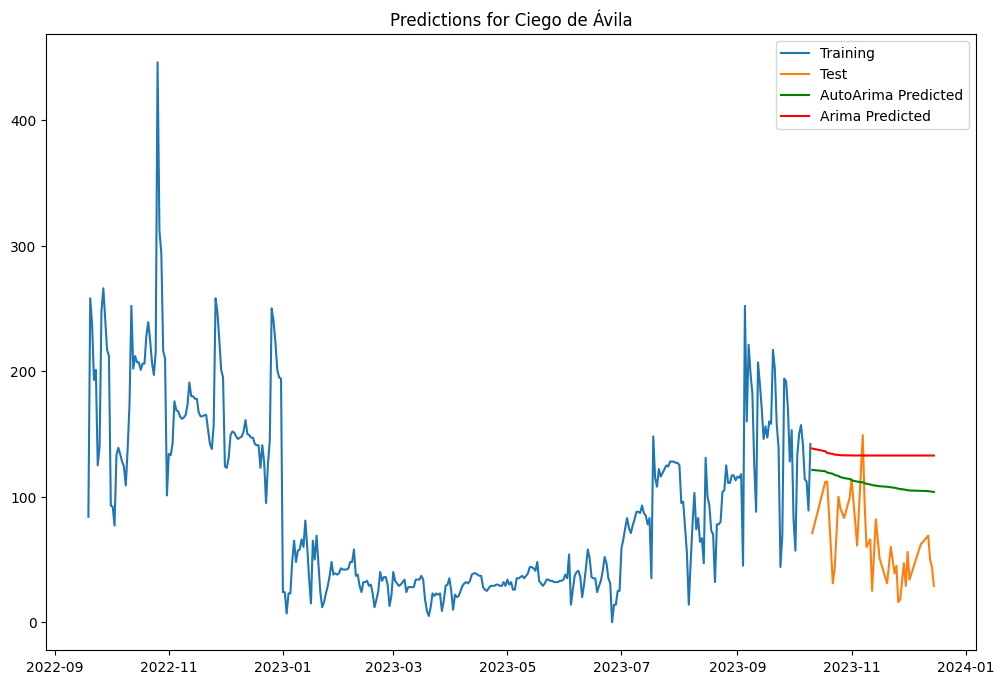

                               SARIMAX Results                                
Dep. Variable:         Ciego de Ávila   No. Observations:                  387
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1874.589
Date:                Thu, 30 Jan 2025   AIC                           3755.178
Time:                        12:50:29   BIC                           3767.046
Sample:                    09-19-2022   HQIC                          3759.884
                         - 10-10-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6059      0.043     14.046      0.000       0.521       0.690
ma.L1         -0.9089      0.026    -34.620      0.000      -0.960      -0.857
sigma2       966.2489     23.441     41.221      0.0

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre

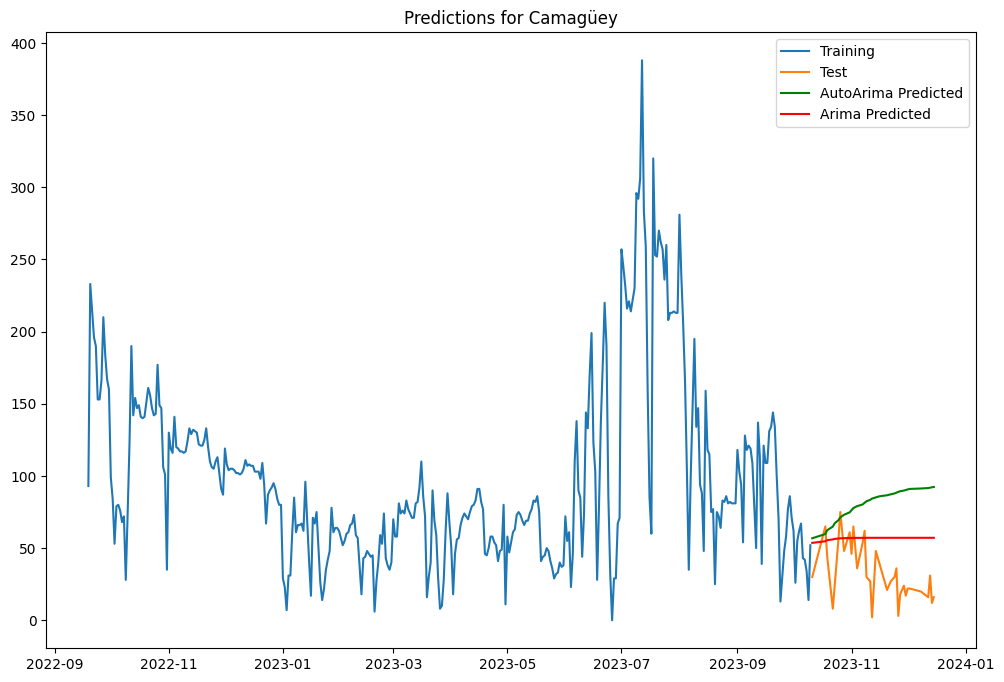

                               SARIMAX Results                                
Dep. Variable:               Camagüey   No. Observations:                  387
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1881.538
Date:                Thu, 30 Jan 2025   AIC                           3769.076
Time:                        12:50:30   BIC                           3780.944
Sample:                    09-19-2022   HQIC                          3773.782
                         - 10-10-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6817      0.033     20.838      0.000       0.618       0.746
ma.L1         -0.9069      0.022    -42.150      0.000      -0.949      -0.865
sigma2      1002.0641     34.107     29.380      0.0

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre

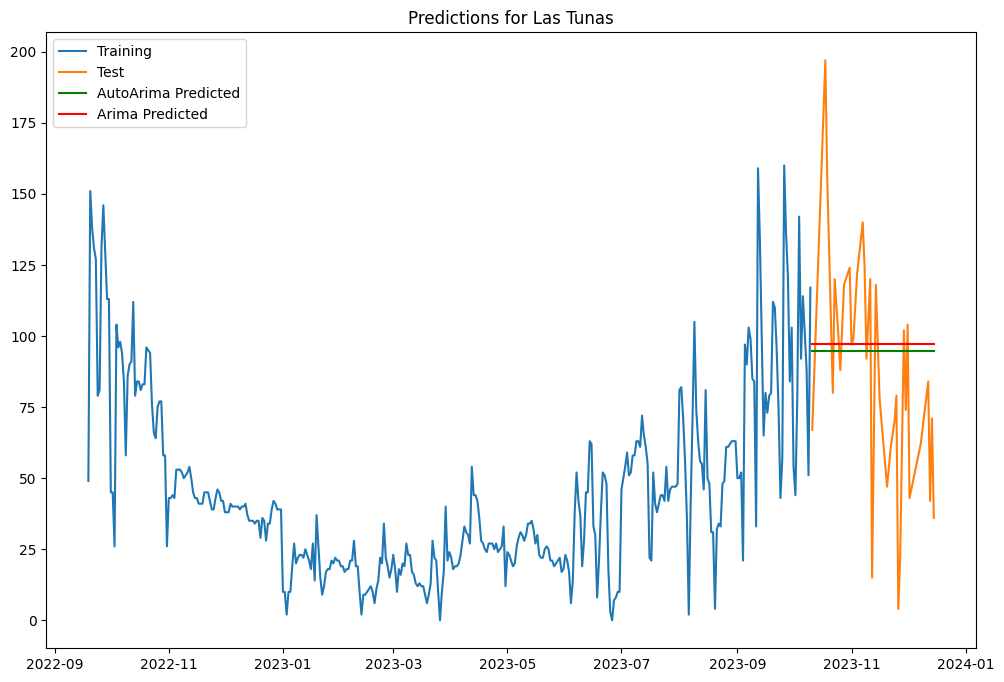

                               SARIMAX Results                                
Dep. Variable:              Las Tunas   No. Observations:                  387
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1651.166
Date:                Thu, 30 Jan 2025   AIC                           3306.331
Time:                        12:50:31   BIC                           3314.243
Sample:                    09-19-2022   HQIC                          3309.469
                         - 10-10-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4079      0.033    -12.477      0.000      -0.472      -0.344
sigma2       303.9654     10.450     29.088      0.000     283.484     324.447
Ljung-Box (L1) (Q):                   8.16   Jarque-

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre

 AutoArima Predictions for Holguin: incomes. d = 0
107     95.733542
108    108.996344
109     70.071015
110    116.521919
111     77.077716
112    118.700842
113     78.194632
114    117.071073
115     76.814727
116    113.873961
117     74.419506
118    110.086498
119     71.654126
120    106.132525
121     68.797880
122    102.193967
123     65.970077
124     98.347016
125     63.220132
126     94.621733
127     60.566992
128     91.028115
129     58.016374
130     87.567505
131     55.568314
132     84.237574
133     53.220459
134     81.034500
135     50.969510
136     77.953919
137     48.811846
138     74.991332
139     46.743791
140     72.142282
dtype: float64

Arima Predictions for Holguin: incomes. d = 1
2023-10-11    130.157079
2023-10-12    116.610200
2023-10-13     86.304547
2023-10-14    116.468074
2023-10-15    103.109136
2023-10-16     80.874872
2023-10-17     93.162046
2023-10-18    110.925743
2023-10-19     99.676108
2023-10-20     85.573015
2023-10-21     95.746022


C:\Users\Melissa\AppData\Local\Temp\ipykernel_19500\1194971014.py:84: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  auto_mape = np.mean(np.abs((curr_test - auto_predictions) / curr_test)) * 100


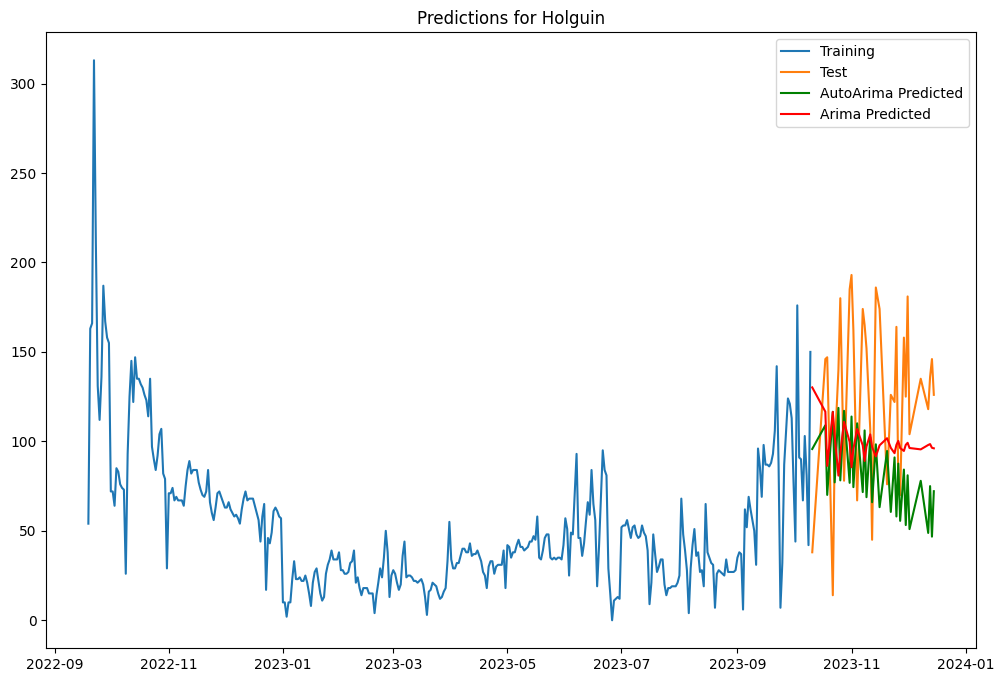

                               SARIMAX Results                                
Dep. Variable:                Holguin   No. Observations:                  387
Model:                 ARIMA(3, 1, 5)   Log Likelihood               -1686.496
Date:                Thu, 30 Jan 2025   AIC                           3390.992
Time:                        12:50:33   BIC                           3426.595
Sample:                    09-19-2022   HQIC                          3405.111
                         - 10-10-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1142      0.073     -1.568      0.117      -0.257       0.029
ar.L2         -0.8342      0.045    -18.464      0.000      -0.923      -0.746
ar.L3         -0.0463      0.080     -0.582      0.5

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre

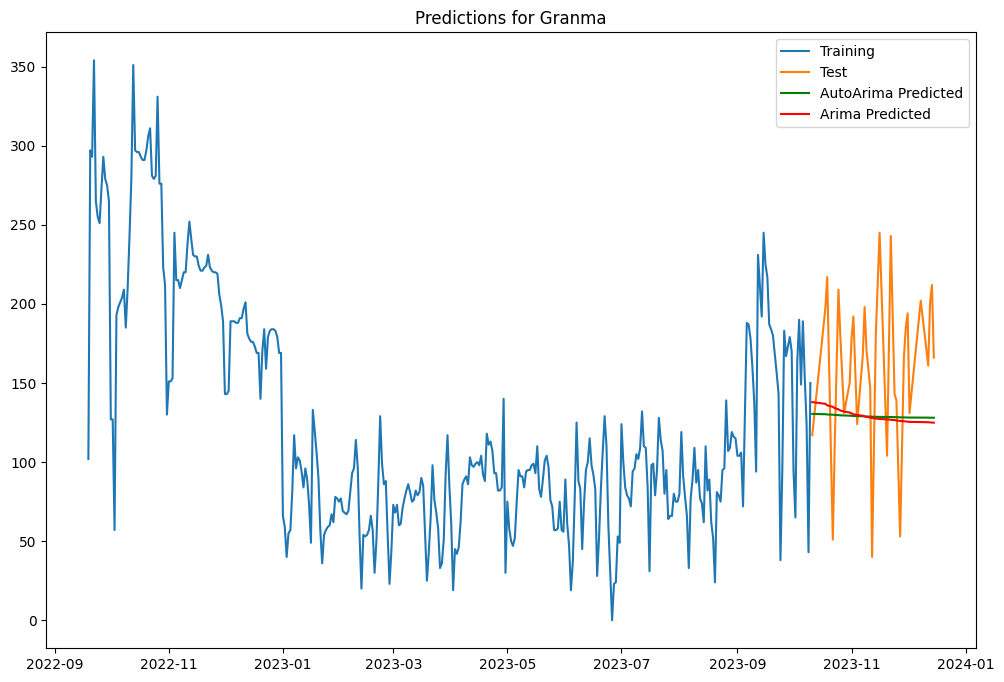

                               SARIMAX Results                                
Dep. Variable:                 Granma   No. Observations:                  387
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1870.002
Date:                Thu, 30 Jan 2025   AIC                           3748.004
Time:                        12:50:34   BIC                           3763.838
Sample:                    09-19-2022   HQIC                          3754.283
                         - 10-10-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        123.8757     19.686      6.292      0.000      85.291     162.460
ar.L1          0.9241      0.023     39.442      0.000       0.878       0.970
ma.L1         -0.1104      0.050     -2.190      0.0

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre

 AutoArima Predictions for Santiago de Cuba: incomes. d = 1
107    123.852110
108     98.313831
109    122.427163
110     78.121591
111     70.484805
112     96.459018
113     70.940525
114     82.380564
115     81.341326
116     53.068489
117     66.326221
118     58.244116
119     47.357602
120     59.036078
121     42.529647
122     37.604292
123     41.608648
124     26.818682
125     29.237912
126     27.119165
127     15.072042
128     17.744788
129     10.669917
130      3.514033
131      5.275421
132     -3.508008
133     -7.306682
134     -8.612888
135    -17.233143
136    -18.955165
137    -22.677580
138    -29.719108
139    -31.140271
140    -36.677212
dtype: float64

Arima Predictions for Santiago de Cuba: incomes. d = 0
2023-10-11    109.785935
2023-10-12    118.076996
2023-10-13    108.531646
2023-10-14    111.538157
2023-10-15    110.401749
2023-10-16    112.375201
2023-10-17    112.121036
2023-10-18    112.776583
2023-10-19    112.845391
2023-10-20    113.300617
2023-10

C:\Users\Melissa\AppData\Local\Temp\ipykernel_19500\1194971014.py:84: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  auto_mape = np.mean(np.abs((curr_test - auto_predictions) / curr_test)) * 100


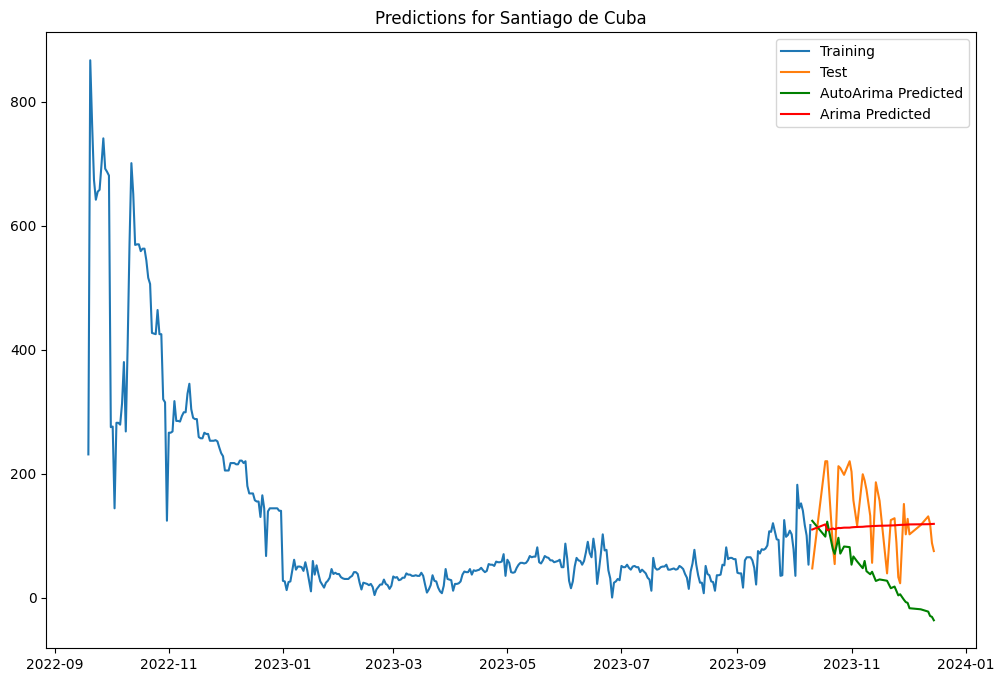

                               SARIMAX Results                                
Dep. Variable:       Santiago de Cuba   No. Observations:                  387
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -2047.733
Date:                Thu, 30 Jan 2025   AIC                           4107.466
Time:                        12:50:35   BIC                           4131.217
Sample:                    09-19-2022   HQIC                          4116.884
                         - 10-10-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        124.5785    124.324      1.002      0.316    -119.092     368.249
ar.L1          0.8163      0.039     21.196      0.000       0.741       0.892
ar.L2          0.1542      0.041      3.788      0.0

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre

 AutoArima Predictions for Guantánamo: incomes. d = 1
107    48.967790
108    45.090943
109    39.794529
110    43.573103
111    34.151137
112    40.200000
113    39.260570
114    34.173192
115    37.185617
116    32.434764
117    33.389651
118    33.511420
119    29.713563
120    30.996544
121    28.623261
122    27.709241
123    27.817726
124    25.211628
125    25.227203
126    23.907747
127    22.499327
128    22.254053
129    20.452306
130    19.777257
131    18.829175
132    17.421976
133    16.832385
134    15.483693
135    14.505651
136    13.628775
137    12.344874
138    11.521207
139    10.390787
140     9.313047
dtype: float64

Arima Predictions for Guantánamo: incomes. d = 0
2023-10-11    37.245483
2023-10-12    37.958185
2023-10-13    43.019166
2023-10-14    42.327709
2023-10-15    42.313998
2023-10-16    41.152072
2023-10-17    41.321064
2023-10-18    41.482494
2023-10-19    41.964669
2023-10-20    42.146655
2023-10-21    42.290715
2023-10-22    42.337385
2023-10-23    4

C:\Users\Melissa\AppData\Local\Temp\ipykernel_19500\1194971014.py:84: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  auto_mape = np.mean(np.abs((curr_test - auto_predictions) / curr_test)) * 100


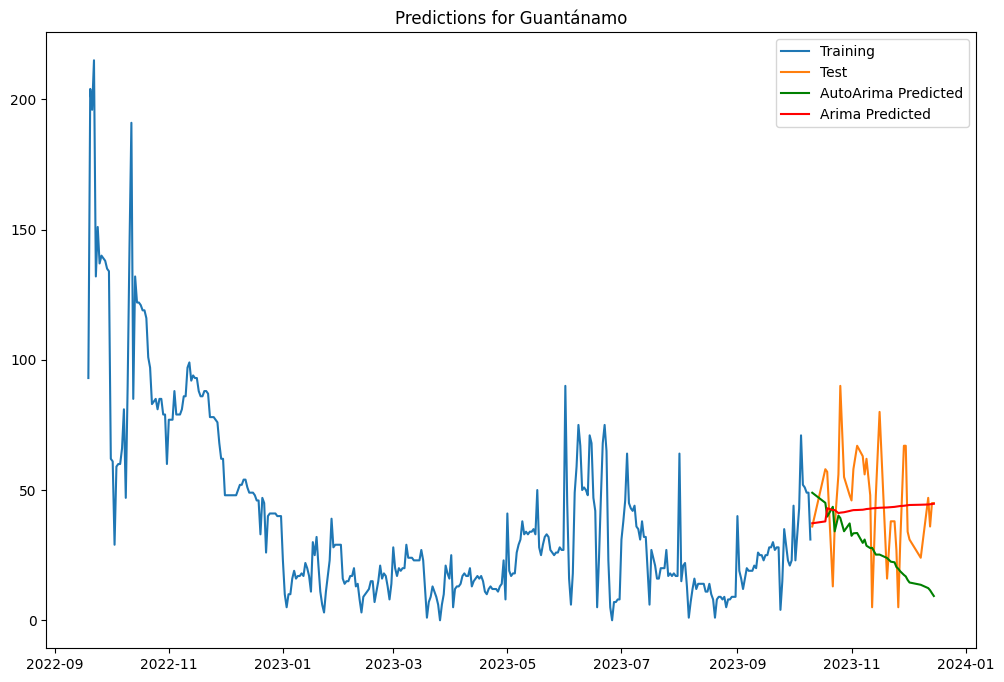

                               SARIMAX Results                                
Dep. Variable:             Guantánamo   No. Observations:                  387
Model:                 ARIMA(4, 0, 1)   Log Likelihood               -1570.494
Date:                Thu, 30 Jan 2025   AIC                           3154.988
Time:                        12:50:37   BIC                           3182.697
Sample:                    09-19-2022   HQIC                          3165.976
                         - 10-10-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.6696     21.874      2.271      0.023       6.798      92.542
ar.L1          1.1283      0.155      7.301      0.000       0.825       1.431
ar.L2         -0.1227      0.113     -1.087      0.2

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferre

 AutoArima Predictions for Isla de la Juventud: incomes. d = 1
107    0.941844
108   -0.371064
109   -0.909976
110   -1.714884
111   -1.808745
112   -1.618634
113   -1.224327
114   -1.078155
115   -1.333686
116   -1.973746
117   -2.721667
118   -3.269372
119   -3.429177
120   -3.252723
121   -2.982360
122   -2.905670
123   -3.183926
124   -3.764986
125   -4.422598
126   -4.896170
127   -5.043820
128   -4.919732
129   -4.733812
130   -4.722582
131   -5.010312
132   -5.541719
133   -6.122161
134   -6.537155
135   -6.678101
136   -6.600757
137   -6.485439
138   -6.526507
139   -6.818612
140   -7.306066
dtype: float64

Arima Predictions for Isla de la Juventud: incomes. d = 0
2023-10-11    0.080397
2023-10-12   -0.044776
2023-10-13    0.379634
2023-10-14    0.578322
2023-10-15    0.485804
2023-10-16    0.736288
2023-10-17    0.965034
2023-10-18    0.929352
2023-10-19    1.066896
2023-10-20    1.276469
2023-10-21    1.292115
2023-10-22    1.365980
2023-10-23    1.536019
2023-10-24    1.5861

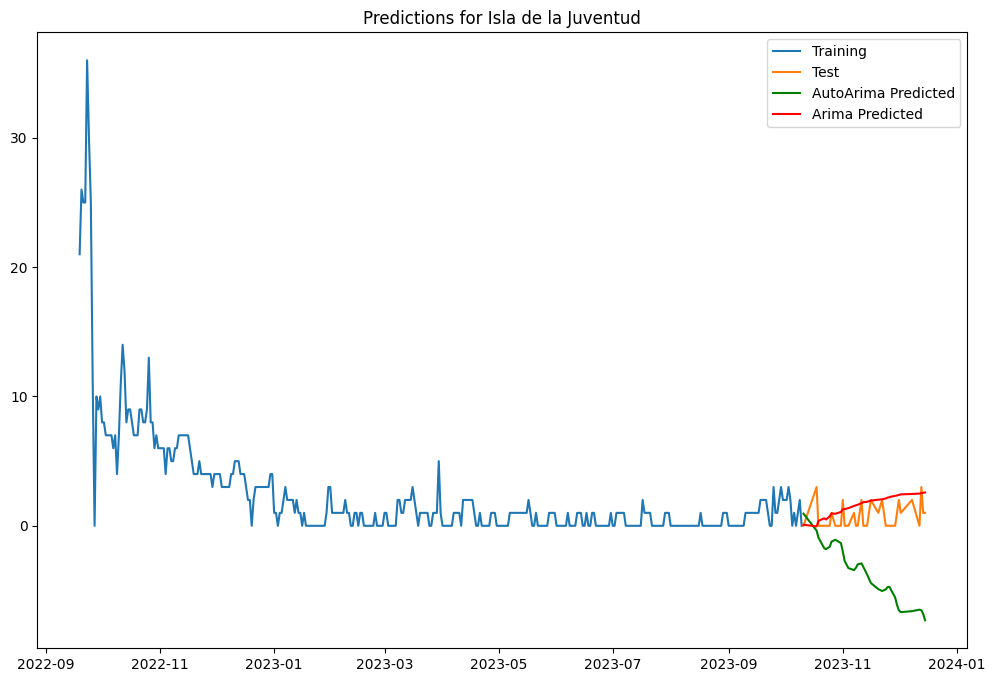

                                SARIMAX Results                                
Dep. Variable:     Isla de la Juventud   No. Observations:                  387
Model:                  ARIMA(3, 0, 2)   Log Likelihood                -716.053
Date:                 Thu, 30 Jan 2025   AIC                           1446.106
Time:                         12:50:40   BIC                           1473.815
Sample:                     09-19-2022   HQIC                          1457.093
                          - 10-10-2023                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0659      1.676      1.829      0.067      -0.219       6.351
ar.L1          0.2901      0.076      3.807      0.000       0.141       0.439
ar.L2         -0.1415      0.105     -1.349 

In [13]:
evaluate_model(models, d_from_diff, aug_trainset, testset)